In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
import seaborn as sns
from IPython.display import Image
import plotly.express as px # ploty
import plotly.graph_objects as go

from tqdm import tqdm
import time

#한글폰트설정
plt.rc('font', family='NanumBarunGothic')
pd.set_option('display.max_rows', 100)


#모델
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier, plot_importance
import lightgbm 


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score


from sklearn.model_selection import TimeSeriesSplit 
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.linear_model import Lars,LassoLars,LassoLarsCV

# import optuna
# from optuna.integration import XGBoostPruningCallback

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings(action='ignore')

import gc, sys
gc.enable() # 자동 가비지 수거 활성화

In [ ]:
# 한글 폰트 확인
import matplotlib.font_manager as fm
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'NanumBarun' in f.name]

[('NanumBarunGothic', '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'),
 ('NanumBarunGothic',
  '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf')]

In [ ]:
base_path = '/content/drive/MyDrive/이어드림스쿨/Project/Final_project/2021 농산물 예측대회 AI 경진대회/2021 농산물 가격예측 AI 경진대회/프로젝트 data/'

In [ ]:
df = pd.read_parquet(base_path + 'modeling_data1(완).parquet')

In [ ]:
df['mean_price'] = df['TOT_AMT'] / df['TOT_QTY']

In [ ]:
df.columns

Index(['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday', 'domestic_mean', 'abroad_mean', 'output',
       'area', '소비자물가지수', '지점명', '온도(최저)', '온도(평균)', '온도(최고)', '지면온도(최저)',
       '지면온도(평균)', '지면온도(최고)', '풍속(m/s)(평균)', '습도(%)(평균)', '강수량(mm)(합계)',
       '적설량(cm)(합계)', '일조량(합계)', '일조량(평균)', 'mean_price'],
      dtype='object')

# test

In [ ]:
df1.PUM_NM.unique()

NameError: ignored

In [ ]:
df1 = df.copy()
df2 = df.copy()

In [ ]:
# 사과
low_amount = df2[df2.PUM_NM == '사과'].mean_price.quantile(0.01)
high_amount = df2[df2.PUM_NM == '사과'].mean_price.quantile(0.99)
print((low_amount, high_amount))

apple = df2[df2.PUM_NM == '사과'].loc[(df2[df2.PUM_NM == '사과'].mean_price >= low_amount) & (df2[df2.PUM_NM == '사과'].mean_price <= high_amount)]
apple = apple.reset_index(drop=True)
print(apple.shape)

(300.0, 6760.0)
(9354947, 29)


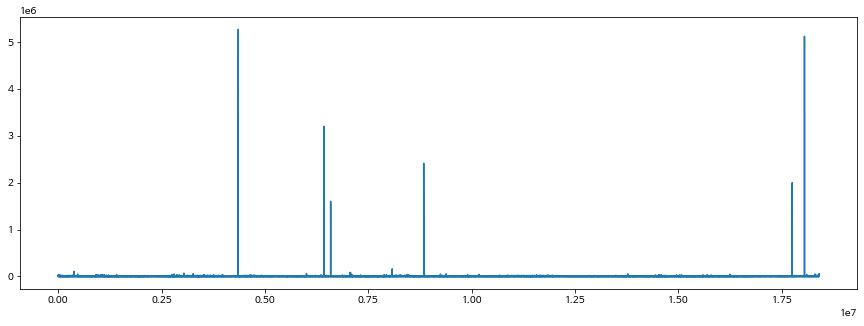

In [ ]:
df1[df1.PUM_NM == '사과']['mean_price'].plot(figsize = (15,5))

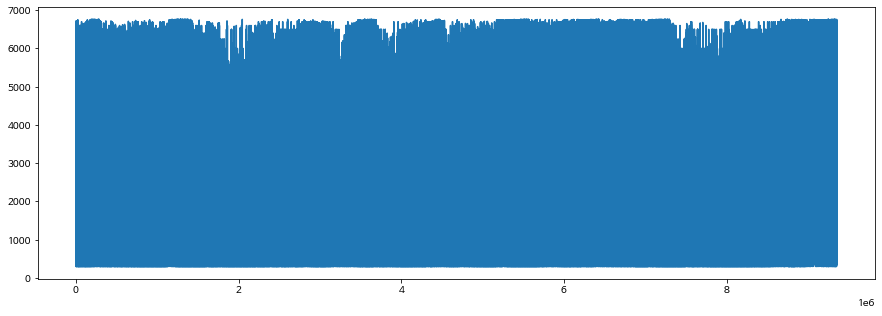

In [ ]:
apple[apple.PUM_NM == '사과']['mean_price'].plot(figsize = (15,5))

의논사항

---
- 시계열 관련 feature
    1. Time_series(time_lag) 기간 선정
    2. 시계열 특징 feature : 요일(Onehot-encoding), 잔차, 트렌트, 시즌 선정
        - prophet으로 요일별 추세가 다른지 확인해보고 결정해도 좋을듯
    3. 이동평균선(rolling) feature 추가, 기간 선정
---
- 외부변수
    4. 기상데이터는 제외하는게 좋을거같은데..
    5. 경제 지표(환율, 금리 등) 추가 여부, 선정
---
- 건고추 이상치 제거, 다른 품종들 이상치 제거

# 모델링 전처리 함수

In [ ]:
# 함수화

def split_train_and_test(df, date, week):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train = df[df['SALEDATE'] < date]
    test = df[df['SALEDATE'] >= date]
    del train['SALEDATE']
    del test['SALEDATE']
    y_train = train.pop(f'{week}week')
    x_train=train.copy()
    y_test = test.pop(f'{week}week')
    x_test=test.copy()
    return x_train,y_train,x_test,y_test

def eval_model(y_test,pred):
    y_true, y_pred = np.array(y_test), np.array(pred)
    mae = mean_absolute_error(y_true, pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print('mae:',mae,'mape:',mape, 'mse:',mse)
    return mae, mape, mse

#시각화 그래프 
def eval_visul(y_test,pred,title,week):
    y_test=y_test.reset_index()[f'{week}week']
    plt.figure(figsize=(20,5))
    plt.title(title, fontsize = 25)
    plt.plot(y_test, label='true')
    plt.plot(pred, label='pred')
    plt.legend()
    plt.show()
    eval_model(y_test,pred)

def mean_price(df_apple):
    df_apple=df_apple.groupby(['SALEDATE']).mean()
    df_apple['mean_price']=df_apple['TOT_AMT']/df_apple['TOT_QTY']
    #사용된 총금액과 총거래량은 제거
    # df_apple=df_apple.drop(columns=['TOT_AMT','TOT_QTY'])
    df_apple=df_apple.reset_index()
    df_apple = df_apple.round()
    #날짜 컬럼 추가
    # df_apple['year'] = df_apple['SALEDATE'].dt.year
    # df_apple['month'] = df_apple['SALEDATE'].dt.month
    # df_apple['day'] = df_apple['SALEDATE'].dt.day
    # df_apple['weekday'] = df_apple['SALEDATE'].dt.weekday
    return df_apple


#n주일 후 가격을 예측하는 컬럼을 추가 
#df-> 예측기간 가격이 0으로 나오는 값 제외, 따로 변수로 지정
def forcast_week(df,week):
    df[f'{week}week']=0
    
    for index in range(len(df)):
        try:df[f'{week}week'][index] = df['mean_price'][index+7*week]
        except:continue
    df_week=df.iloc[-7*week:]
    df = df.drop(df.iloc[-7*week:].index)
    return df, df_week

def forcast_1week(df_1):
    df_1['1week']=0
    for index in range(len(df_1)):
        try:df_1['1week'][index] = df_1['mean_price'][index+7]
        except:continue
    #df_1_week=df_1.iloc[-7*week:]
    df_1 = df_1.drop(df_1.iloc[-7:].index)
    return df_1

# time_lag
def train_serise(df_apple, time):
    for lag in range(1,time + 1):
        df_apple[f'p_lag_{lag}'] = -1
        #df_apple[f'q_lag_{lag}'] = -1
        for index in range(lag, len(df_apple)):
            df_apple.loc[index, f'p_lag_{lag}'] = df_apple['mean_price'][index-lag] #1일전, 2일전, ... 가격을 feature로 추가
            #df_apple.loc[index, f'q_lag_{lag}'] = df_apple['TOT_QTY'][index-lag] #1일전, 2일전, ... 거래량을 feature로 추가
    return df_apple


#요일컬럼 추가 -> 원 핫 인코딩
def weekday(df_test):
    weekday=['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    df_test['요일']=0
    for i in range(len(df_test)):
        df_test['요일'][i]=weekday[df_test['SALEDATE'][i].weekday()]
    df_test = pd.concat([df_test, pd.get_dummies(df_test['요일'])], axis=1)
    df_test =df_test.drop(columns='요일')
    return df_test

#시계열 분해 잔차활용
def resid(df):
    date_resid=STL(df[['SALEDATE','mean_price']].set_index('SALEDATE'), period=12)
    df['resid']=date_resid.fit().resid.values
    return df

#시계열 분해 트렌드활용
def trend(df):
    date_resid=STL(df[['SALEDATE','mean_price']].set_index('SALEDATE'), period=12)
    df['trend']=date_resid.fit().trend.values
    return df

#시계열 분해 시즌활용
def season(df):
    date_resid=STL(df[['SALEDATE','mean_price']].set_index('SALEDATE'), period=12)
    df['season']=date_resid.fit().seasonal.values
    return df

In [ ]:
# 다양한 경우의 feature로 모델링 진행

# 1. 기본 
def selcet_pum1(df, pum):
    df_apple = df[df['PUM_NM']==pum]
    df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday']]
    df_apple = mean_price(df_apple)
    df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple

# 2. 기본 + time_lag
def selcet_pum2(df, pum):
    df_apple = df[df['PUM_NM']==pum]
    df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday']]
    df_apple = mean_price(df_apple)
    df_apple = train_serise(df_apple) 
    df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple


# 3. 기본 + 시계열 특징 feature
def selcet_pum3(df, pum):
    df_apple = df[df['PUM_NM']==pum]
    df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday']]
    df_apple = mean_price(df_apple)
    df_apple = resid(df_apple)
    df_apple = trend(df_apple)
    df_apple = season(df_apple)
    df_apple = weekday(df_apple)
    df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple


# 4. 기본 + 외부변수
def selcet_pum4(df, pum):
    df_apple=df[df['PUM_NM']==pum]
    df_apple = mean_price(df_apple)
    df_apple=forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple


# 5. 기본 + time_lag + 시계열 특징 feature
def selcet_pum5(df, pum):
    df_apple = df[df['PUM_NM']==pum]
    df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday']]
    df_apple = mean_price(df_apple)
    df_apple = train_serise(df_apple)
    df_apple = resid(df_apple)
    df_apple = trend(df_apple)
    df_apple = season(df_apple)
    df_apple = weekday(df_apple)
    df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple

# 5. 기본 + time_lag + 시계열 특징 feature
def selcet_pum5(df, pum):
    df_apple = df[df['PUM_NM']==pum]
    df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY']]
    df_apple = mean_price(df_apple)
    df_apple = train_serise(df_apple)
    df_apple = resid(df_apple)
    df_apple = trend(df_apple)
    # df_apple = season(df_apple)
    # df_apple = weekday(df_apple)
    df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple


# 6. 기본 + 외부변수 + 시계열 특징 feature
def selcet_pum6(df, pum):
    df_apple=df[df['PUM_NM']==pum]
    df_apple = mean_price(df_apple)
    df_apple = resid(df_apple)
    df_apple = trend(df_apple)
    df_apple = season(df_apple)
    df_apple = weekday(df_apple)
    df_apple=forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple


# 7. 기본 + 외부변수 + time_lag
def selcet_pum7(df, pum):
    df_apple=df[df['PUM_NM']==pum]
    df_apple = mean_price(df_apple)
    df_apple = train_serise(df_apple)
    df_apple=forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple

# 8. 기본 + 외부변수 + time_lag + 시계열 특징 feature
def selcet_pum8(df, pum):
    df_apple=df[df['PUM_NM']==pum]
    df_apple = mean_price(df_apple)
    df_apple = train_serise(df_apple)
    df_apple = resid(df_apple)
    df_apple = trend(df_apple)
    df_apple = season(df_apple)
    df_apple = weekday(df_apple)
    df_apple=forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple

In [ ]:
def pre_1(df, pum) : 
    df_pum=selcet_pum1(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = StandardScaler()
    # scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test


def pre_2(df, pum) : 
    df_pum=selcet_pum2(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = StandardScaler()
    # scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test


def pre_3(df, pum) : 
    df_pum=selcet_pum3(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = StandardScaler()
    # scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test


def pre_4(df, pum) : 
    df_pum=selcet_pum4(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = StandardScaler()
    # scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test


def pre_5(df, pum) : 
    df_pum=selcet_pum5(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = StandardScaler()
    # scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test


def pre_6(df, pum) : 
    df_pum=selcet_pum6(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = StandardScaler()
    # scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test


def pre_7(df, pum) : 
    df_pum=selcet_pum7(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = StandardScaler()
    # scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test

def pre_8(df, pum) : 
    df_pum=selcet_pum8(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = StandardScaler()
    # scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test

In [ ]:
def MAPE(y, y_pred):
    mape = mean_absolute_percentage_error(y, y_pred)
    return mape

# 기본 feature만 사용
def mape_cv1(model, df, pum):
    train_X, test_X, train_y, test_y = pre_1(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X)), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        print("First train_day: {}\t Last train_day: {}".format(X_train[:1].index[0], X_train[-1:].index[0]))
        print("First val_day: {}\t Last val_day: {}".format(X_test[:1].index[0], X_test[-1:].index[0]))
        print('-' * 40)
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv2(model, df, pum):
    train_X, test_X, train_y, test_y = pre_2(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X)), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        print("First train_day: {}\t Last train_day: {}".format(X_train[:1].index[0], X_train[-1:].index[0]))
        print("First val_day: {}\t Last val_day: {}".format(X_test[:1].index[0], X_test[-1:].index[0]))
        print('-' * 40)
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv3(model, df, pum):
    train_X, test_X, train_y, test_y = pre_3(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X)), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        print("First train_day: {}\t Last train_day: {}".format(X_train[:1].index[0], X_train[-1:].index[0]))
        print("First val_day: {}\t Last val_day: {}".format(X_test[:1].index[0], X_test[-1:].index[0]))
        print('-' * 40)
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv4(model, df, pum):
    train_X, test_X, train_y, test_y = pre_4(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X)), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        print("First train_day: {}\t Last train_day: {}".format(X_train[:1].index[0], X_train[-1:].index[0]))
        print("First val_day: {}\t Last val_day: {}".format(X_test[:1].index[0], X_test[-1:].index[0]))
        print('-' * 40)
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv5(model, df, pum):
    train_X, test_X, train_y, test_y = pre_5(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X)), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        print("First train_day: {}\t Last train_day: {}".format(X_train[:1].index[0], X_train[-1:].index[0]))
        print("First val_day: {}\t Last val_day: {}".format(X_test[:1].index[0], X_test[-1:].index[0]))
        print('-' * 40)
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv6(model, df, pum):
    train_X, test_X, train_y, test_y = pre_6(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X)), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        print("First train_day: {}\t Last train_day: {}".format(X_train[:1].index[0], X_train[-1:].index[0]))
        print("First val_day: {}\t Last val_day: {}".format(X_test[:1].index[0], X_test[-1:].index[0]))
        print('-' * 40)
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv7(model, df, pum):
    train_X, test_X, train_y, test_y = pre_7(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X)), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        print("First train_day: {}\t Last train_day: {}".format(X_train[:1].index[0], X_train[-1:].index[0]))
        print("First val_day: {}\t Last val_day: {}".format(X_test[:1].index[0], X_test[-1:].index[0]))
        print('-' * 40)
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv8(model, df, pum):
    train_X, test_X, train_y, test_y = pre_8(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X)), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        print("First train_day: {}\t Last train_day: {}".format(X_train[:1].index[0], X_train[-1:].index[0]))
        print("First val_day: {}\t Last val_day: {}".format(X_test[:1].index[0], X_test[-1:].index[0]))
        print('-' * 40)
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list


# 기본 feature만 사용
def print_mape_score1(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv1(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score2(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv2(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score3(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv3(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score4(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv4(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score5(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv5(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score6(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv6(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score7(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv7(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score8(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv8(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [ ]:
def modeling1(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score1(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 - MAPE', fontsize=15)
    plt.show()

def modeling2(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score2(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 + time_lag - MAPE', fontsize=15)
    plt.show()

def modeling3(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score3(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 + 시계열 특징 feature - MAPE', fontsize=15)
    plt.show()

def modeling4(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score4(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0,1)
    plt.title(f'{pum} : 기본 + 외부변수 - MAPE', fontsize=15)
    plt.show()

def modeling5(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score5(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 + time_lag + 시계열 특징 feature - MAPE', fontsize=15)
    plt.show()

def modeling6(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score6(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 + 외부변수 + 시계열 특징 feature - MAPE', fontsize=15)
    plt.show()

def modeling7(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score7(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 + 외부변수 + time_lag - MAPE', fontsize=15)
    plt.show()

def modeling8(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score8(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 + 외부변수 + time_lag + 시계열 특징 feature - MAPE', fontsize=15)
    plt.show()

In [ ]:
reg2 = LinearRegression()
ridge2 = Ridge()
lasso2 = Lasso()
Enet2 = ElasticNet()
DTree2 = DecisionTreeRegressor()
rf2 = RandomForestRegressor()
model_xgb2 = XGBRegressor()
model_lgb2 = LGBMRegressor()

# 배추 품종으로 실험 진행(참고)

In [ ]:
df.head()

,SALEDATE,PUM_NM,KIND_NM,SAN_NM,TOT_AMT,TOT_QTY,year,month,day,weekday,...,지면온도(최저),지면온도(평균),지면온도(최고),풍속(m/s)(평균),습도(%)(평균),강수량(mm)(합계),적설량(cm)(합계),일조량(합계),일조량(평균),mean_price
0,2016-01-01,사과,후지,충북 충주,26000.00,15.00,2016,1,1,4,...,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32,1733.33
1,2016-01-01,사과,후지,충북 충주,20000.00,40.00,2016,1,1,4,...,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32,500.00
2,2016-01-01,사과,후지,충북 충주,10500.00,14.00,2016,1,1,4,...,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32,750.00
3,2016-01-01,사과,후지,충북 충주,210000.00,240.00,2016,1,1,4,...,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32,875.00
4,2016-01-01,사과,후지,충북 충주,175000.00,140.00,2016,1,1,4,...,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32,1250.00


In [ ]:
bae = df[df.PUM_NM == '배추']

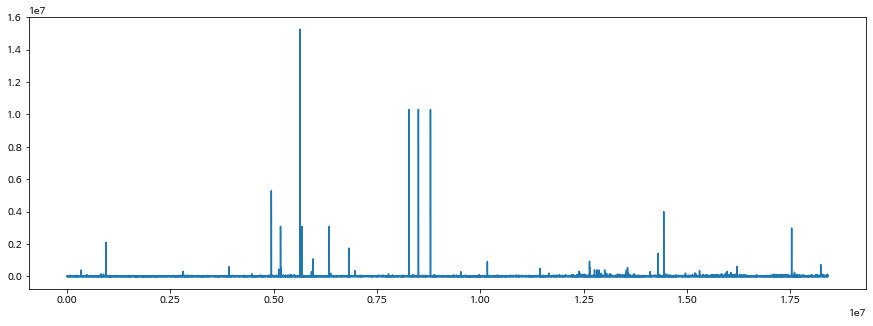

In [ ]:
bae.mean_price.plot(figsize = (15,5))

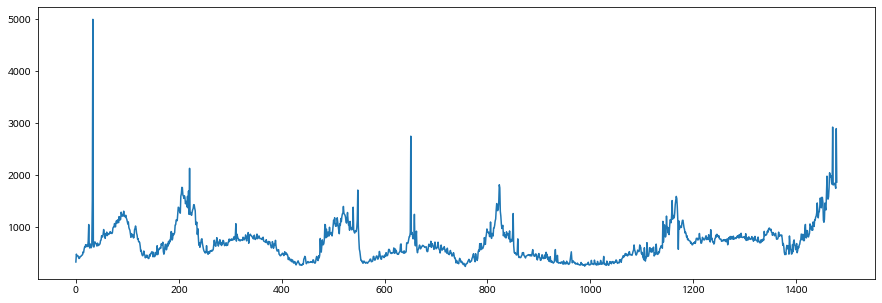

In [ ]:
bae2 = mean_price(bae)
bae2.mean_price.plot(figsize = (15,5))

### 함수 수정하면서 진행

In [ ]:
# # 5. 기본 + time_lag + 시계열 특징 feature
# def selcet_pum5(df, pum):
#     df_apple = df[df['PUM_NM']==pum]
#     df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
#        'month', 'day', 'weekday']]
#     df_apple = mean_price(df_apple)
#     df_apple = train_serise(df_apple)
#     df_apple = resid(df_apple)
#     df_apple = trend(df_apple)
#     df_apple = season(df_apple)
#     df_apple = weekday(df_apple)
#     df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
#     return df_apple

In [ ]:
# 함수 실시간으로 수정하면서 같은 modeling2 함수로 진행한거라 다시 실행하면 다르게 나옵니다!
# 출력된 내용은 다시 실행하지 말고 보셔야합니다!

def selcet_pum2(df, pum, time):
    df_apple = df[df['PUM_NM']==pum]
    df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday']]
    df_apple = mean_price(df_apple)
    df_apple = train_serise(df_apple, time)
    df_apple = resid(df_apple)
    df_apple = trend(df_apple)
    df_apple = season(df_apple)
    # df_apple = weekday(df_apple)
    df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple

def pre_2(df, pum, time) : 
    df_pum=selcet_pum2(df, pum, time)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = StandardScaler()
    # scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test

def mape_cv2(model, df, pum, time):
    train_X, test_X, train_y, test_y = pre_2(df, pum, time)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X)), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        print("First train_day: {}\t Last train_day: {}".format(X_train[:1].index[0], X_train[-1:].index[0]))
        print("First val_day: {}\t Last val_day: {}".format(X_test[:1].index[0], X_test[-1:].index[0]))
        print('-' * 40)
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list


def print_mape_score2(model, df, pum, time):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv2(model, df, pum, time)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

def modeling2(df, pum, time) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score2(model, df, pum, time)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 + time_lag - MAPE', fontsize=15)
    plt.show()

#### time_lag 7일

(1159, 14) (1159,) (314, 14) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 77.71it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LinearRegression MAPE: 0.1687
2 FOLDS: LinearRegression MAPE: 0.2448
3 FOLDS: LinearRegression MAPE: 0.1530
4 FOLDS: LinearRegression MAPE: 0.2060
5 FOLDS: LinearRegression MAPE: 0.1815

LinearRegression mean MAPE: 0.1908


(1159, 14) (1159,) (314, 14) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 149.46it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Ridge MAPE: 0.1672
2 FOLDS: Ridge MAPE: 0.2451
3 FOLDS: Ridge MAPE: 0.1518
4 FOLDS: Ridge MAPE: 0.2051
5 FOLDS: Ridge MAPE: 0.1811

Ridge mean MAPE: 0.1901


(1159, 14) (1159,) (314, 14) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 139.10it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Lasso MAPE: 0.1667
2 FOLDS: Lasso MAPE: 0.2474
3 FOLDS: Lasso MAPE: 0.1499
4 FOLDS: Lasso MAPE: 0.2031
5 FOLDS: Lasso MAPE: 0.1819

Lasso mean MAPE: 0.1898


(1159, 14) (1159,) (314, 14) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 150.97it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: ElasticNet MAPE: 0.1517
2 FOLDS: ElasticNet MAPE: 0.3607
3 FOLDS: ElasticNet MAPE: 0.1777
4 FOLDS: ElasticNet MAPE: 0.2090
5 FOLDS: ElasticNet MAPE: 0.1965

ElasticNet mean MAPE: 0.2191


(1159, 14) (1159,) (314, 14) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 100.26it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: DecisionTreeRegressor MAPE: 0.3295
2 FOLDS: DecisionTreeRegressor MAPE: 0.4336
3 FOLDS: DecisionTreeRegressor MAPE: 0.1991
4 FOLDS: DecisionTreeRegressor MAPE: 0.2762
5 FOLDS: DecisionTreeRegressor MAPE: 0.2060

DecisionTreeRegressor mean MAPE: 0.2889


(1159, 14) (1159,) (314, 14) (314,)


RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:01,  5.59it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------


RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:01,  4.19it/s]

First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------


RandomForestRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:02,  3.27it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


RandomForestRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:02,  2.64it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  2.56it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1952
2 FOLDS: RandomForestRegressor MAPE: 0.3895
3 FOLDS: RandomForestRegressor MAPE: 0.1495
4 FOLDS: RandomForestRegressor MAPE: 0.2035
5 FOLDS: RandomForestRegressor MAPE: 0.1653

RandomForestRegressor mean MAPE: 0.2206
(1159, 14) (1159,) (314, 14) (314,)


XGBRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
[08:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:01,  5.93it/s]

First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
[08:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
[08:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
[08:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
[08:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  5.52it/s]


1 FOLDS: XGBRegressor MAPE: 0.2529
2 FOLDS: XGBRegressor MAPE: 0.3130
3 FOLDS: XGBRegressor MAPE: 0.1513
4 FOLDS: XGBRegressor MAPE: 0.2440
5 FOLDS: XGBRegressor MAPE: 0.1900

XGBRegressor mean MAPE: 0.2302
(1159, 14) (1159,) (314, 14) (314,)


LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 16.69it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 10.58it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LGBMRegressor MAPE: 0.1923
2 FOLDS: LGBMRegressor MAPE: 0.4147
3 FOLDS: LGBMRegressor MAPE: 0.1703
4 FOLDS: LGBMRegressor MAPE: 0.2394
5 FOLDS: LGBMRegressor MAPE: 0.1681

LGBMRegressor mean MAPE: 0.2370


,Model,Score
0,LinearRegression,0.19
1,Ridge,0.19
2,Lasso,0.19
3,ElasticNet,0.22
4,DecisionTreeRegressor,0.29
5,RandomForestRegressor,0.22
6,XGBRegressor,0.23
7,LGBMRegressor,0.24


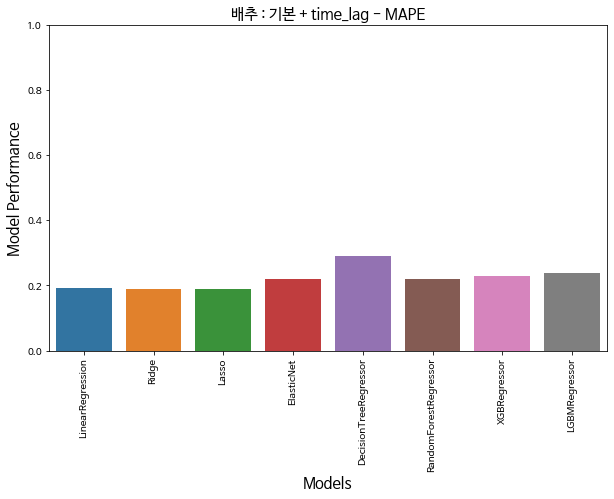

In [ ]:
# time_lag 7일
modeling2(df, '배추', 7)

(1159, 15) (1159,) (314, 15) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 165.21it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LinearRegression MAPE: 0.1688
2 FOLDS: LinearRegression MAPE: 0.2451
3 FOLDS: LinearRegression MAPE: 0.1528
4 FOLDS: LinearRegression MAPE: 0.2057
5 FOLDS: LinearRegression MAPE: 0.1819

LinearRegression mean MAPE: 0.1908


(1159, 15) (1159,) (314, 15) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 176.61it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Ridge MAPE: 0.1673
2 FOLDS: Ridge MAPE: 0.2454
3 FOLDS: Ridge MAPE: 0.1516
4 FOLDS: Ridge MAPE: 0.2048
5 FOLDS: Ridge MAPE: 0.1815

Ridge mean MAPE: 0.1901


(1159, 15) (1159,) (314, 15) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 146.15it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Lasso MAPE: 0.1667
2 FOLDS: Lasso MAPE: 0.2473
3 FOLDS: Lasso MAPE: 0.1496
4 FOLDS: Lasso MAPE: 0.2029
5 FOLDS: Lasso MAPE: 0.1823

Lasso mean MAPE: 0.1898


(1159, 15) (1159,) (314, 15) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 139.34it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: ElasticNet MAPE: 0.1534
2 FOLDS: ElasticNet MAPE: 0.3607
3 FOLDS: ElasticNet MAPE: 0.1775
4 FOLDS: ElasticNet MAPE: 0.2090
5 FOLDS: ElasticNet MAPE: 0.1962

ElasticNet mean MAPE: 0.2194


(1159, 15) (1159,) (314, 15) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 109.90it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: DecisionTreeRegressor MAPE: 0.3351
2 FOLDS: DecisionTreeRegressor MAPE: 0.4492
3 FOLDS: DecisionTreeRegressor MAPE: 0.1994
4 FOLDS: DecisionTreeRegressor MAPE: 0.3016
5 FOLDS: DecisionTreeRegressor MAPE: 0.2296

DecisionTreeRegressor mean MAPE: 0.3030


(1159, 15) (1159,) (314, 15) (314,)


RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:01,  5.34it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------


RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:01,  4.03it/s]

First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------


RandomForestRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:02,  3.15it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


RandomForestRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:02,  2.51it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.43it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1992
2 FOLDS: RandomForestRegressor MAPE: 0.3942
3 FOLDS: RandomForestRegressor MAPE: 0.1477
4 FOLDS: RandomForestRegressor MAPE: 0.2051
5 FOLDS: RandomForestRegressor MAPE: 0.1723

RandomForestRegressor mean MAPE: 0.2237
(1159, 15) (1159,) (314, 15) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 22.50it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
[08:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
[08:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
[08:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
[08:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 16.91it/s]


First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
[08:42:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.2294
2 FOLDS: XGBRegressor MAPE: 0.3435
3 FOLDS: XGBRegressor MAPE: 0.1456
4 FOLDS: XGBRegressor MAPE: 0.2425
5 FOLDS: XGBRegressor MAPE: 0.1853

XGBRegressor mean MAPE: 0.2293
(1159, 15) (1159,) (314, 15) (314,)


LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 17.62it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 10.38it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LGBMRegressor MAPE: 0.1760
2 FOLDS: LGBMRegressor MAPE: 0.3966
3 FOLDS: LGBMRegressor MAPE: 0.1718
4 FOLDS: LGBMRegressor MAPE: 0.2347
5 FOLDS: LGBMRegressor MAPE: 0.1810

LGBMRegressor mean MAPE: 0.2320


,Model,Score
0,LinearRegression,0.19
1,Ridge,0.19
2,Lasso,0.19
3,ElasticNet,0.22
4,DecisionTreeRegressor,0.30
5,RandomForestRegressor,0.22
6,XGBRegressor,0.23
7,LGBMRegressor,0.23


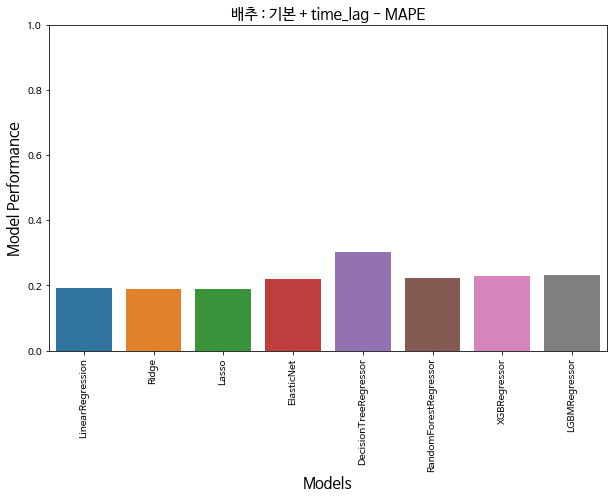

In [ ]:
# time_lag 8일
modeling2(df, '배추', 8)

(1159, 16) (1159,) (314, 16) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 149.56it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LinearRegression MAPE: 0.1685
2 FOLDS: LinearRegression MAPE: 0.2455
3 FOLDS: LinearRegression MAPE: 0.1548
4 FOLDS: LinearRegression MAPE: 0.2062
5 FOLDS: LinearRegression MAPE: 0.1825

LinearRegression mean MAPE: 0.1915


(1159, 16) (1159,) (314, 16) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 153.44it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Ridge MAPE: 0.1671
2 FOLDS: Ridge MAPE: 0.2456
3 FOLDS: Ridge MAPE: 0.1535
4 FOLDS: Ridge MAPE: 0.2053
5 FOLDS: Ridge MAPE: 0.1821

Ridge mean MAPE: 0.1907


(1159, 16) (1159,) (314, 16) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 136.77it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Lasso MAPE: 0.1665
2 FOLDS: Lasso MAPE: 0.2472
3 FOLDS: Lasso MAPE: 0.1514
4 FOLDS: Lasso MAPE: 0.2034
5 FOLDS: Lasso MAPE: 0.1829

Lasso mean MAPE: 0.1903


(1159, 16) (1159,) (314, 16) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 161.17it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: ElasticNet MAPE: 0.1550
2 FOLDS: ElasticNet MAPE: 0.3607
3 FOLDS: ElasticNet MAPE: 0.1776
4 FOLDS: ElasticNet MAPE: 0.2090
5 FOLDS: ElasticNet MAPE: 0.1961

ElasticNet mean MAPE: 0.2197


(1159, 16) (1159,) (314, 16) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 97.01it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: DecisionTreeRegressor MAPE: 0.3280
2 FOLDS: DecisionTreeRegressor MAPE: 0.4810
3 FOLDS: DecisionTreeRegressor MAPE: 0.2105
4 FOLDS: DecisionTreeRegressor MAPE: 0.2699
5 FOLDS: DecisionTreeRegressor MAPE: 0.2402

DecisionTreeRegressor mean MAPE: 0.3059


(1159, 16) (1159,) (314, 16) (314,)


RandomForestRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------


RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:01,  5.08it/s]

First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------


RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:02,  3.89it/s]

First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------


RandomForestRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:02,  3.02it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


RandomForestRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:02,  2.37it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.29it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2109
2 FOLDS: RandomForestRegressor MAPE: 0.3987
3 FOLDS: RandomForestRegressor MAPE: 0.1525
4 FOLDS: RandomForestRegressor MAPE: 0.2020
5 FOLDS: RandomForestRegressor MAPE: 0.1759

RandomForestRegressor mean MAPE: 0.2280
(1159, 16) (1159,) (314, 16) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 21.18it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
[08:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
[08:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
[08:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
[08:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 15.81it/s]


First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
[08:43:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.2182
2 FOLDS: XGBRegressor MAPE: 0.3521
3 FOLDS: XGBRegressor MAPE: 0.1446
4 FOLDS: XGBRegressor MAPE: 0.2409
5 FOLDS: XGBRegressor MAPE: 0.1982

XGBRegressor mean MAPE: 0.2308
(1159, 16) (1159,) (314, 16) (314,)


LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 17.42it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.97it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LGBMRegressor MAPE: 0.1720
2 FOLDS: LGBMRegressor MAPE: 0.4075
3 FOLDS: LGBMRegressor MAPE: 0.1716
4 FOLDS: LGBMRegressor MAPE: 0.2435
5 FOLDS: LGBMRegressor MAPE: 0.1668

LGBMRegressor mean MAPE: 0.2323


,Model,Score
0,LinearRegression,0.19
1,Ridge,0.19
2,Lasso,0.19
3,ElasticNet,0.22
4,DecisionTreeRegressor,0.31
5,RandomForestRegressor,0.23
6,XGBRegressor,0.23
7,LGBMRegressor,0.23


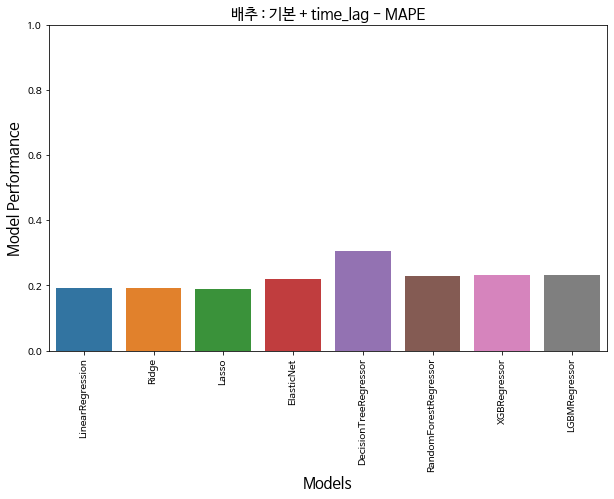

In [ ]:
# time_lag 9일
modeling2(df, '배추', 9)

(1159, 35) (1159,) (314, 35) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 119.19it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LinearRegression MAPE: 0.1851
2 FOLDS: LinearRegression MAPE: 0.2710
3 FOLDS: LinearRegression MAPE: 0.1533
4 FOLDS: LinearRegression MAPE: 0.1922
5 FOLDS: LinearRegression MAPE: 0.1964

LinearRegression mean MAPE: 0.1996


(1159, 35) (1159,) (314, 35) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 117.00it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Ridge MAPE: 0.1838
2 FOLDS: Ridge MAPE: 0.2724
3 FOLDS: Ridge MAPE: 0.1530
4 FOLDS: Ridge MAPE: 0.1913
5 FOLDS: Ridge MAPE: 0.1961

Ridge mean MAPE: 0.1993


(1159, 35) (1159,) (314, 35) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 115.44it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Lasso MAPE: 0.1823
2 FOLDS: Lasso MAPE: 0.2762
3 FOLDS: Lasso MAPE: 0.1511
4 FOLDS: Lasso MAPE: 0.1908
5 FOLDS: Lasso MAPE: 0.1979

Lasso mean MAPE: 0.1996


(1159, 35) (1159,) (314, 35) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 116.25it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: ElasticNet MAPE: 0.1419
2 FOLDS: ElasticNet MAPE: 0.3569
3 FOLDS: ElasticNet MAPE: 0.2242
4 FOLDS: ElasticNet MAPE: 0.2047
5 FOLDS: ElasticNet MAPE: 0.2260

ElasticNet mean MAPE: 0.2307


(1159, 35) (1159,) (314, 35) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 60.31it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: DecisionTreeRegressor MAPE: 0.2223
2 FOLDS: DecisionTreeRegressor MAPE: 0.4326
3 FOLDS: DecisionTreeRegressor MAPE: 0.2715
4 FOLDS: DecisionTreeRegressor MAPE: 0.2797
5 FOLDS: DecisionTreeRegressor MAPE: 0.2683

DecisionTreeRegressor mean MAPE: 0.2949


(1159, 35) (1159,) (314, 35) (314,)


RandomForestRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------


RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:02,  3.65it/s]

First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------


RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:03,  2.39it/s]

First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------


RandomForestRegressor Cross Validations...:  30%|███       | 3/10 [00:01<00:04,  1.73it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


RandomForestRegressor Cross Validations...:  40%|████      | 4/10 [00:02<00:04,  1.30it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.26it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1775
2 FOLDS: RandomForestRegressor MAPE: 0.4110
3 FOLDS: RandomForestRegressor MAPE: 0.1914
4 FOLDS: RandomForestRegressor MAPE: 0.1973
5 FOLDS: RandomForestRegressor MAPE: 0.1989

RandomForestRegressor mean MAPE: 0.2352
(1159, 35) (1159,) (314, 35) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 14.52it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
[08:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
[08:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
[08:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00,  9.21it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
[08:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
[08:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.38it/s]


1 FOLDS: XGBRegressor MAPE: 0.2130
2 FOLDS: XGBRegressor MAPE: 0.4251
3 FOLDS: XGBRegressor MAPE: 0.1641
4 FOLDS: XGBRegressor MAPE: 0.2575
5 FOLDS: XGBRegressor MAPE: 0.2030

XGBRegressor mean MAPE: 0.2526
(1159, 35) (1159,) (314, 35) (314,)


LGBMRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 12.45it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


LGBMRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:01,  4.73it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  4.26it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1696
2 FOLDS: LGBMRegressor MAPE: 0.4124
3 FOLDS: LGBMRegressor MAPE: 0.1884
4 FOLDS: LGBMRegressor MAPE: 0.2108
5 FOLDS: LGBMRegressor MAPE: 0.1741

LGBMRegressor mean MAPE: 0.2311


,Model,Score
0,LinearRegression,0.20
1,Ridge,0.20
2,Lasso,0.20
3,ElasticNet,0.23
4,DecisionTreeRegressor,0.29
5,RandomForestRegressor,0.24
6,XGBRegressor,0.25
7,LGBMRegressor,0.23


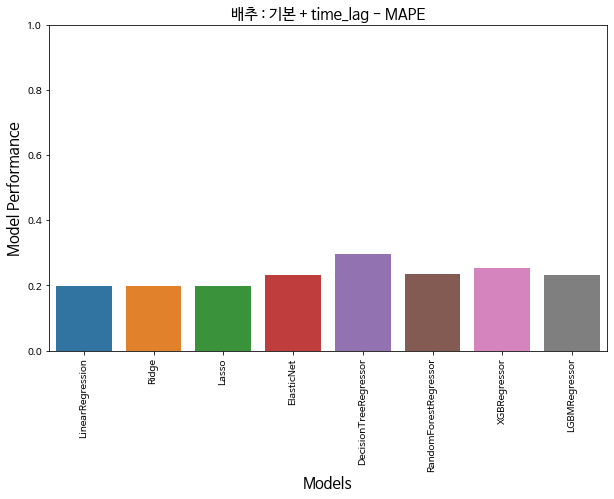

In [ ]:
# time_lag 28일
modeling2(df, '배추', 28)

#### time_lag + 요일 컬럼 + 시계열

(1159, 24) (1159,) (314, 24) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 140.76it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LinearRegression MAPE: 0.1445
2 FOLDS: LinearRegression MAPE: 0.1365
3 FOLDS: LinearRegression MAPE: 0.1189
4 FOLDS: LinearRegression MAPE: 0.1189
5 FOLDS: LinearRegression MAPE: 0.0886

LinearRegression mean MAPE: 0.1215


(1159, 24) (1159,) (314, 24) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 143.59it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Ridge MAPE: 0.1446
2 FOLDS: Ridge MAPE: 0.1390
3 FOLDS: Ridge MAPE: 0.1167
4 FOLDS: Ridge MAPE: 0.1195
5 FOLDS: Ridge MAPE: 0.0889

Ridge mean MAPE: 0.1218


(1159, 24) (1159,) (314, 24) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 102.42it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Lasso MAPE: 0.1401
2 FOLDS: Lasso MAPE: 0.1454
3 FOLDS: Lasso MAPE: 0.1146
4 FOLDS: Lasso MAPE: 0.1235
5 FOLDS: Lasso MAPE: 0.0904

Lasso mean MAPE: 0.1228


(1159, 24) (1159,) (314, 24) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 131.09it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: ElasticNet MAPE: 0.1460
2 FOLDS: ElasticNet MAPE: 0.3149
3 FOLDS: ElasticNet MAPE: 0.1566
4 FOLDS: ElasticNet MAPE: 0.1923
5 FOLDS: ElasticNet MAPE: 0.1721

ElasticNet mean MAPE: 0.1964


(1159, 24) (1159,) (314, 24) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 91.98it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: DecisionTreeRegressor MAPE: 0.2868
2 FOLDS: DecisionTreeRegressor MAPE: 0.5169
3 FOLDS: DecisionTreeRegressor MAPE: 0.1720
4 FOLDS: DecisionTreeRegressor MAPE: 0.1898
5 FOLDS: DecisionTreeRegressor MAPE: 0.1727

DecisionTreeRegressor mean MAPE: 0.2676


(1159, 24) (1159,) (314, 24) (314,)


RandomForestRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------


RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:01,  4.83it/s]

First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------


RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:02,  3.51it/s]

First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------


RandomForestRegressor Cross Validations...:  30%|███       | 3/10 [00:01<00:02,  2.64it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


RandomForestRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:02,  2.11it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.04it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1815
2 FOLDS: RandomForestRegressor MAPE: 0.3428
3 FOLDS: RandomForestRegressor MAPE: 0.1370
4 FOLDS: RandomForestRegressor MAPE: 0.1484
5 FOLDS: RandomForestRegressor MAPE: 0.1333

RandomForestRegressor mean MAPE: 0.1886
(1159, 24) (1159,) (314, 24) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 18.40it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
[08:56:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
[08:56:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
[08:56:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
[08:56:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 13.40it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
[08:56:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.2597
2 FOLDS: XGBRegressor MAPE: 0.3073
3 FOLDS: XGBRegressor MAPE: 0.1450
4 FOLDS: XGBRegressor MAPE: 0.1793
5 FOLDS: XGBRegressor MAPE: 0.1446

XGBRegressor mean MAPE: 0.2072


(1159, 24) (1159,) (314, 24) (314,)


LGBMRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------


LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 14.42it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.24it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1570
2 FOLDS: LGBMRegressor MAPE: 0.3316
3 FOLDS: LGBMRegressor MAPE: 0.1572
4 FOLDS: LGBMRegressor MAPE: 0.1676
5 FOLDS: LGBMRegressor MAPE: 0.1233

LGBMRegressor mean MAPE: 0.1873


,Model,Score
0,LinearRegression,0.12
1,Ridge,0.12
2,Lasso,0.12
3,ElasticNet,0.20
4,DecisionTreeRegressor,0.27
5,RandomForestRegressor,0.19
6,XGBRegressor,0.21
7,LGBMRegressor,0.19


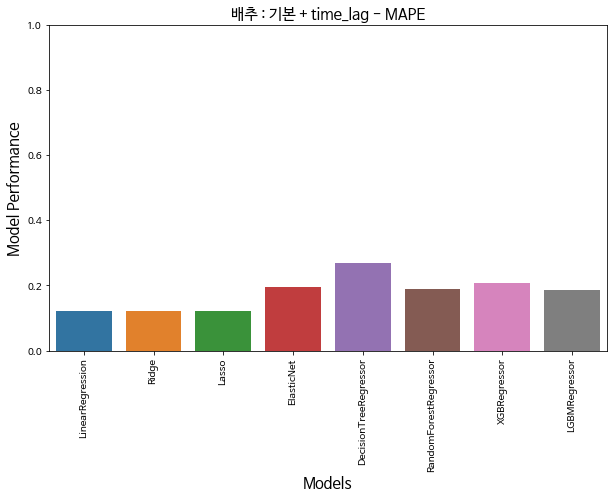

In [ ]:
# 요일 추가
modeling2(df, '배추', 7)

#### time_lag + 요일 빼고 

(1159, 17) (1159,) (314, 17) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 155.65it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LinearRegression MAPE: 0.1093
2 FOLDS: LinearRegression MAPE: 0.1342
3 FOLDS: LinearRegression MAPE: 0.1175
4 FOLDS: LinearRegression MAPE: 0.1184
5 FOLDS: LinearRegression MAPE: 0.0875

LinearRegression mean MAPE: 0.1134


(1159, 17) (1159,) (314, 17) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 129.89it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Ridge MAPE: 0.1102
2 FOLDS: Ridge MAPE: 0.1369
3 FOLDS: Ridge MAPE: 0.1154
4 FOLDS: Ridge MAPE: 0.1192
5 FOLDS: Ridge MAPE: 0.0879

Ridge mean MAPE: 0.1139


(1159, 17) (1159,) (314, 17) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 116.26it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Lasso MAPE: 0.1104
2 FOLDS: Lasso MAPE: 0.1436
3 FOLDS: Lasso MAPE: 0.1137
4 FOLDS: Lasso MAPE: 0.1228
5 FOLDS: Lasso MAPE: 0.0906

Lasso mean MAPE: 0.1162


(1159, 17) (1159,) (314, 17) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 139.46it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: ElasticNet MAPE: 0.1354
2 FOLDS: ElasticNet MAPE: 0.3125
3 FOLDS: ElasticNet MAPE: 0.1567
4 FOLDS: ElasticNet MAPE: 0.1912
5 FOLDS: ElasticNet MAPE: 0.1739

ElasticNet mean MAPE: 0.1939


(1159, 17) (1159,) (314, 17) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 92.18it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: DecisionTreeRegressor MAPE: 0.2543
2 FOLDS: DecisionTreeRegressor MAPE: 0.3447
3 FOLDS: DecisionTreeRegressor MAPE: 0.1729
4 FOLDS: DecisionTreeRegressor MAPE: 0.2131
5 FOLDS: DecisionTreeRegressor MAPE: 0.1536

DecisionTreeRegressor mean MAPE: 0.2277


(1159, 17) (1159,) (314, 17) (314,)


RandomForestRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------


RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:01,  5.00it/s]

First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------


RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:02,  3.70it/s]

First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------


RandomForestRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:02,  2.87it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


RandomForestRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:02,  2.27it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.21it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1733
2 FOLDS: RandomForestRegressor MAPE: 0.3424
3 FOLDS: RandomForestRegressor MAPE: 0.1414
4 FOLDS: RandomForestRegressor MAPE: 0.1503
5 FOLDS: RandomForestRegressor MAPE: 0.1296

RandomForestRegressor mean MAPE: 0.1874
(1159, 17) (1159,) (314, 17) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 20.43it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
[08:57:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
[08:57:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
[08:57:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
[08:57:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 14.97it/s]


First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
[08:57:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.2548
2 FOLDS: XGBRegressor MAPE: 0.3073
3 FOLDS: XGBRegressor MAPE: 0.1432
4 FOLDS: XGBRegressor MAPE: 0.1821
5 FOLDS: XGBRegressor MAPE: 0.1400

XGBRegressor mean MAPE: 0.2055
(1159, 17) (1159,) (314, 17) (314,)


LGBMRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------


LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 15.54it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.79it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1570
2 FOLDS: LGBMRegressor MAPE: 0.3313
3 FOLDS: LGBMRegressor MAPE: 0.1567
4 FOLDS: LGBMRegressor MAPE: 0.1720
5 FOLDS: LGBMRegressor MAPE: 0.1251

LGBMRegressor mean MAPE: 0.1884


,Model,Score
0,LinearRegression,0.11
1,Ridge,0.11
2,Lasso,0.12
3,ElasticNet,0.19
4,DecisionTreeRegressor,0.23
5,RandomForestRegressor,0.19
6,XGBRegressor,0.21
7,LGBMRegressor,0.19


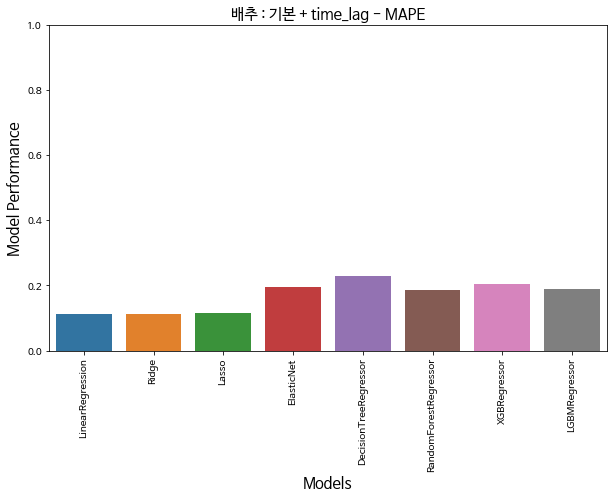

In [ ]:
# 요일 빼고 다른 시계열 feature 
modeling2(df, '배추', 7)

## 10/17(월)
요일 컬럼 큰 성능 향상은 없음

In [ ]:
def add_price(df_pum):
  df_pum["mean_price_5"]= df_pum["mean_price"].rolling(5).mean().shift(1) # 지난 5일간 평균 가격
  df_pum["mean_price_30"]= df_pum["mean_price"].rolling(21).mean().shift(1) # 지난달 평균 가격 
  df_pum["ratio_mean_price_5_30"] = df_pum["mean_price_5"]/df_pum["mean_price_30"] # 5일간/지난달 비율 
  return df_pum

def add_TOT_QTY(df_pum):
  df_pum["TOT_QTY_5"]= df_pum["TOT_QTY"].rolling(5).mean().shift(1) # 지난 5일간 평균 거래량
  df_pum["TOT_QTY_30"]= df_pum["TOT_QTY"].rolling(21).mean().shift(1) # 지난달 평균 거래량 
  df_pum["ratio_TOT_QTY_5_30"] = df_pum["TOT_QTY_5"]/df_pum["TOT_QTY_30"]
  return df_pum

def add_std_price(df_pum):
  df_pum["std_price_5"]= df_pum["mean_price"].rolling(5).std().shift(1) # 지난 5일간 평균 가격 표준편차
  df_pum["std_price_30"]= df_pum["mean_price"].rolling(21).std().shift(1) # 지난달 평균 가격 표준편차 
  df_pum["ratio_std_price_5_30"] = df_pum["std_price_5"] / df_pum["std_price_30"]
  return df_pum

def add_std_TOT_QTY(df_pum):
  df_pum["std_TOT_QTY_5"]= df_pum["TOT_QTY"].rolling(5).std().shift(1) # 지난 5일간 평균 거래량 표준편차
  df_pum["std_TOT_QTY_30"]= df_pum["TOT_QTY"].rolling(21).std().shift(1) # 지난달 평균 거래량 표준편차 
  df_pum["ratio_std_TOT_QTY_5_30"] = df_pum["std_TOT_QTY_5"]/df_pum["std_TOT_QTY_30"]
  return df_pum

# def generate_feature(df_pum):
#   df_new = pd.DataFrame()
#   add_time_feature(df_pum, df_new)
#   add_original_feature(df_pum, df_new)
#   add_price (df_pum, df_new)
#   add_TOT_QTY(df_pum, df_new)
#   add_std_price(df_pum, df_new)
#   add_std_TOT_QTY(df_pum, df_new)
#   df_new = df_new.dropna(axis=0)
#   df_new = df_new.reset_index()
#   return df_new

In [ ]:
# 함수 실시간으로 수정하면서 같은 modeling2 함수로 진행한거라 다시 실행하면 다르게 나옵니다!
# 출력된 내용은 지우지 말고, 다시 실행하지 말고 보셔야합니다!

# def selcet_pum2(df, pum, time):
#     df_apple = df[df['PUM_NM']==pum]
#     df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
#        'month', 'day', 'weekday', 'domestic_mean', 'abroad_mean', 'output',
#        'area', 'mean_price']]
#     df_apple = mean_price(df_apple)
#     df_apple = train_serise(df_apple, time)
#     # df_apple = add_price(df_apple)
#     # df_apple = add_std_price(df_apple)
#     # df_apple = add_TOT_QTY(df_apple)    
#     # df_apple = add_std_TOT_QTY(df_apple)
#     df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
#     df_apple = df_apple.dropna(axis=0)
#     return df_apple

# 5. 기본 + time_lag + 시계열 특징 feature
def selcet_pum2(df, pum, time):
    df_apple = df[df['PUM_NM']==pum]
    df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY']]
    df_apple = mean_price(df_apple)
    df_apple = train_serise(df_apple, time)
    df_apple = resid(df_apple)
    df_apple = trend(df_apple)
    # df_apple = season(df_apple)
    # df_apple = weekday(df_apple)
    df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple

def pre_2(df, pum, time) : 
    df_pum=selcet_pum2(df, pum, time)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = StandardScaler()
    # scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test

def mape_cv2(model, df, pum, time):
    train_X, test_X, train_y, test_y = pre_2(df, pum, time)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X)), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        print("First train_day: {}\t Last train_day: {}".format(X_train[:1].index[0], X_train[-1:].index[0]))
        print("First val_day: {}\t Last val_day: {}".format(X_test[:1].index[0], X_test[-1:].index[0]))
        print('-' * 40)
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list


def print_mape_score2(model, df, pum, time):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv2(model, df, pum, time)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def modeling2(df, pum, time) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score2(model, df, pum, time)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'배추 : 기본 + time_lag - MAPE', fontsize=15)
    plt.show()

#### time_lag + 가격 이동평균선

(1138, 20) (1138,) (314, 20) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 95.01it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: LinearRegression MAPE: 0.1646
2 FOLDS: LinearRegression MAPE: 0.2823
3 FOLDS: LinearRegression MAPE: 0.1659
4 FOLDS: LinearRegression MAPE: 0.2223
5 FOLDS: LinearRegression MAPE: 0.1842

LinearRegression mean MAPE: 0.2039


(1138, 20) (1138,) (314, 20) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 120.12it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: Ridge MAPE: 0.1660
2 FOLDS: Ridge MAPE: 0.2793
3 FOLDS: Ridge MAPE: 0.1653
4 FOLDS: Ridge MAPE: 0.2215
5 FOLDS: Ridge MAPE: 0.1838

Ridge mean MAPE: 0.2032


(1138, 20) (1138,) (314, 20) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 104.93it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: Lasso MAPE: 0.1639
2 FOLDS: Lasso MAPE: 0.2751
3 FOLDS: Lasso MAPE: 0.1627
4 FOLDS: Lasso MAPE: 0.2181
5 FOLDS: Lasso MAPE: 0.1856

Lasso mean MAPE: 0.2011


(1138, 20) (1138,) (314, 20) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 127.30it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: ElasticNet MAPE: 0.1551
2 FOLDS: ElasticNet MAPE: 0.3076
3 FOLDS: ElasticNet MAPE: 0.1693
4 FOLDS: ElasticNet MAPE: 0.2047
5 FOLDS: ElasticNet MAPE: 0.2018

ElasticNet mean MAPE: 0.2077


(1138, 20) (1138,) (314, 20) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 81.68it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: DecisionTreeRegressor MAPE: 0.2210
2 FOLDS: DecisionTreeRegressor MAPE: 0.5280
3 FOLDS: DecisionTreeRegressor MAPE: 0.1969
4 FOLDS: DecisionTreeRegressor MAPE: 0.2971
5 FOLDS: DecisionTreeRegressor MAPE: 0.1904

DecisionTreeRegressor mean MAPE: 0.2867


(1138, 20) (1138,) (314, 20) (314,)


RandomForestRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------


RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:01,  4.58it/s]

First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------


RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:02,  3.27it/s]

First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------


RandomForestRegressor Cross Validations...:  30%|███       | 3/10 [00:01<00:02,  2.50it/s]

First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------


RandomForestRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:03,  1.97it/s]

First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.93it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1602
2 FOLDS: RandomForestRegressor MAPE: 0.4627
3 FOLDS: RandomForestRegressor MAPE: 0.1623
4 FOLDS: RandomForestRegressor MAPE: 0.2103
5 FOLDS: RandomForestRegressor MAPE: 0.1647

RandomForestRegressor mean MAPE: 0.2320
(1138, 20) (1138,) (314, 20) (314,)


XGBRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
[00:16:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:01,  5.19it/s]

First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
[00:16:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
[00:16:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
[00:16:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  5.50it/s]


First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
[00:16:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1786
2 FOLDS: XGBRegressor MAPE: 0.4265
3 FOLDS: XGBRegressor MAPE: 0.1414
4 FOLDS: XGBRegressor MAPE: 0.2283
5 FOLDS: XGBRegressor MAPE: 0.1710

XGBRegressor mean MAPE: 0.2292
(1138, 20) (1138,) (314, 20) (314,)


LGBMRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 18.03it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------


LGBMRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00,  6.28it/s]

First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  5.80it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1906
2 FOLDS: LGBMRegressor MAPE: 0.4163
3 FOLDS: LGBMRegressor MAPE: 0.1629
4 FOLDS: LGBMRegressor MAPE: 0.2103
5 FOLDS: LGBMRegressor MAPE: 0.1569

LGBMRegressor mean MAPE: 0.2274


,Model,Score
0,LinearRegression,0.20
1,Ridge,0.20
2,Lasso,0.20
3,ElasticNet,0.21
4,DecisionTreeRegressor,0.29
5,RandomForestRegressor,0.23
6,XGBRegressor,0.23
7,LGBMRegressor,0.23


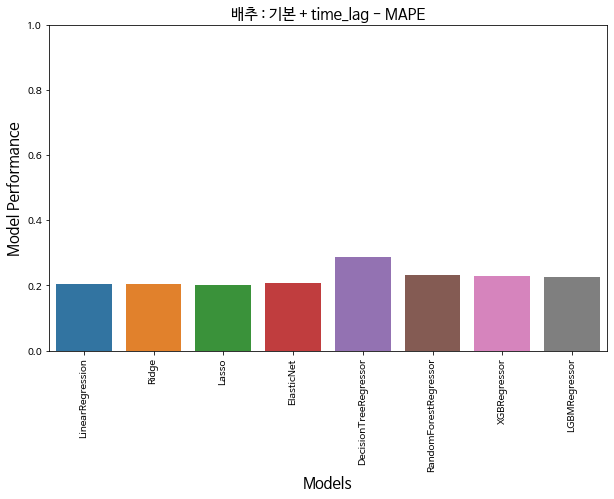

In [ ]:
# 가격 이동평균선만 사용

modeling2(df, '배추', 7)

#### time_lag + 가격, 거래량 이동평균선

(1138, 26) (1138,) (314, 26) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 133.60it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: LinearRegression MAPE: 0.4101
2 FOLDS: LinearRegression MAPE: 0.2945
3 FOLDS: LinearRegression MAPE: 0.1966
4 FOLDS: LinearRegression MAPE: 0.3341
5 FOLDS: LinearRegression MAPE: 0.1927

LinearRegression mean MAPE: 0.2856


(1138, 26) (1138,) (314, 26) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 141.28it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: Ridge MAPE: 0.1572
2 FOLDS: Ridge MAPE: 0.2825
3 FOLDS: Ridge MAPE: 0.1948
4 FOLDS: Ridge MAPE: 0.3283
5 FOLDS: Ridge MAPE: 0.1921

Ridge mean MAPE: 0.2310


(1138, 26) (1138,) (314, 26) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 104.40it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: Lasso MAPE: 0.1527
2 FOLDS: Lasso MAPE: 0.2715
3 FOLDS: Lasso MAPE: 0.1864
4 FOLDS: Lasso MAPE: 0.3012
5 FOLDS: Lasso MAPE: 0.1949

Lasso mean MAPE: 0.2213


(1138, 26) (1138,) (314, 26) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 137.66it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: ElasticNet MAPE: 0.1525
2 FOLDS: ElasticNet MAPE: 0.2970
3 FOLDS: ElasticNet MAPE: 0.1749
4 FOLDS: ElasticNet MAPE: 0.2052
5 FOLDS: ElasticNet MAPE: 0.2135

ElasticNet mean MAPE: 0.2086


(1138, 26) (1138,) (314, 26) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 77.21it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: DecisionTreeRegressor MAPE: 0.2040
2 FOLDS: DecisionTreeRegressor MAPE: 0.5713
3 FOLDS: DecisionTreeRegressor MAPE: 0.1983
4 FOLDS: DecisionTreeRegressor MAPE: 0.2585
5 FOLDS: DecisionTreeRegressor MAPE: 0.2254

DecisionTreeRegressor mean MAPE: 0.2915


(1138, 26) (1138,) (314, 26) (314,)


RandomForestRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------


RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:02,  4.11it/s]

First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------


RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:02,  2.82it/s]

First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------


RandomForestRegressor Cross Validations...:  30%|███       | 3/10 [00:01<00:03,  2.13it/s]

First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------


RandomForestRegressor Cross Validations...:  40%|████      | 4/10 [00:02<00:03,  1.65it/s]

First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.60it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1828
2 FOLDS: RandomForestRegressor MAPE: 0.4509
3 FOLDS: RandomForestRegressor MAPE: 0.1586
4 FOLDS: RandomForestRegressor MAPE: 0.2353
5 FOLDS: RandomForestRegressor MAPE: 0.1953

RandomForestRegressor mean MAPE: 0.2446
(1138, 26) (1138,) (314, 26) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 18.51it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
[00:19:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
[00:19:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
[00:19:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
[00:19:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 11.95it/s]

First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
[00:19:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 10.88it/s]


1 FOLDS: XGBRegressor MAPE: 0.1664
2 FOLDS: XGBRegressor MAPE: 0.3653
3 FOLDS: XGBRegressor MAPE: 0.1478
4 FOLDS: XGBRegressor MAPE: 0.3103
5 FOLDS: XGBRegressor MAPE: 0.2101

XGBRegressor mean MAPE: 0.2400
(1138, 26) (1138,) (314, 26) (314,)


LGBMRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 16.63it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------


LGBMRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00,  6.46it/s]

First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  5.76it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1719
2 FOLDS: LGBMRegressor MAPE: 0.4217
3 FOLDS: LGBMRegressor MAPE: 0.1727
4 FOLDS: LGBMRegressor MAPE: 0.2507
5 FOLDS: LGBMRegressor MAPE: 0.1839

LGBMRegressor mean MAPE: 0.2402


,Model,Score
0,LinearRegression,0.29
1,Ridge,0.23
2,Lasso,0.22
3,ElasticNet,0.21
4,DecisionTreeRegressor,0.29
5,RandomForestRegressor,0.24
6,XGBRegressor,0.24
7,LGBMRegressor,0.24


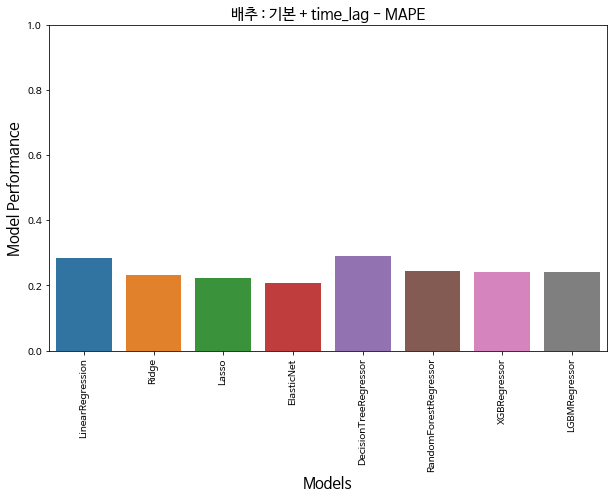

In [ ]:
# 가격 + 거래량 이동평균선 사용

modeling2(df, '배추', 7)

가격 이동평균선만 사용

In [ ]:
df.head()

,SALEDATE,PUM_NM,KIND_NM,SAN_NM,TOT_AMT,TOT_QTY,year,month,day,weekday,...,지면온도(최저),지면온도(평균),지면온도(최고),풍속(m/s)(평균),습도(%)(평균),강수량(mm)(합계),적설량(cm)(합계),일조량(합계),일조량(평균),mean_price
0,2016-01-01,사과,후지,충북 충주,26000.00,15.00,2016,1,1,4,...,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32,1733.33
1,2016-01-01,사과,후지,충북 충주,20000.00,40.00,2016,1,1,4,...,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32,500.00
2,2016-01-01,사과,후지,충북 충주,10500.00,14.00,2016,1,1,4,...,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32,750.00
3,2016-01-01,사과,후지,충북 충주,210000.00,240.00,2016,1,1,4,...,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32,875.00
4,2016-01-01,사과,후지,충북 충주,175000.00,140.00,2016,1,1,4,...,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32,1250.00


In [ ]:
df.columns

Index(['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday', 'domestic_mean', 'abroad_mean', 'output',
       'area', '소비자물가지수', '지점명', '온도(최저)', '온도(평균)', '온도(최고)', '지면온도(최저)',
       '지면온도(평균)', '지면온도(최고)', '풍속(m/s)(평균)', '습도(%)(평균)', '강수량(mm)(합계)',
       '적설량(cm)(합계)', '일조량(합계)', '일조량(평균)', 'mean_price'],
      dtype='object')

#### time_lag + 외부변수 사용 (기상 X)

(1159, 18) (1159,) (314, 18) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 148.73it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LinearRegression MAPE: 0.5917
2 FOLDS: LinearRegression MAPE: 0.4420
3 FOLDS: LinearRegression MAPE: 0.1994
4 FOLDS: LinearRegression MAPE: 0.3598
5 FOLDS: LinearRegression MAPE: 0.2589

LinearRegression mean MAPE: 0.3703


(1159, 18) (1159,) (314, 18) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 139.50it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Ridge MAPE: 0.5227
2 FOLDS: Ridge MAPE: 0.4276
3 FOLDS: Ridge MAPE: 0.1964
4 FOLDS: Ridge MAPE: 0.3549
5 FOLDS: Ridge MAPE: 0.2243

Ridge mean MAPE: 0.3452


(1159, 18) (1159,) (314, 18) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 113.50it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Lasso MAPE: 0.5211
2 FOLDS: Lasso MAPE: 0.3442
3 FOLDS: Lasso MAPE: 0.1817
4 FOLDS: Lasso MAPE: 0.3153
5 FOLDS: Lasso MAPE: 0.1646

Lasso mean MAPE: 0.3054


(1159, 18) (1159,) (314, 18) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 135.03it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: ElasticNet MAPE: 0.1557
2 FOLDS: ElasticNet MAPE: 0.3405
3 FOLDS: ElasticNet MAPE: 0.1353
4 FOLDS: ElasticNet MAPE: 0.2420
5 FOLDS: ElasticNet MAPE: 0.2188

ElasticNet mean MAPE: 0.2184


(1159, 18) (1159,) (314, 18) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 103.57it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: DecisionTreeRegressor MAPE: 0.3093
2 FOLDS: DecisionTreeRegressor MAPE: 0.4105
3 FOLDS: DecisionTreeRegressor MAPE: 0.2157
4 FOLDS: DecisionTreeRegressor MAPE: 0.2575
5 FOLDS: DecisionTreeRegressor MAPE: 0.1817

DecisionTreeRegressor mean MAPE: 0.2749


(1159, 18) (1159,) (314, 18) (314,)


RandomForestRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------


RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:01,  5.01it/s]

First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------


RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:02,  3.67it/s]

First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------


RandomForestRegressor Cross Validations...:  30%|███       | 3/10 [00:01<00:03,  2.27it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


RandomForestRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:02,  2.03it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.03it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2146
2 FOLDS: RandomForestRegressor MAPE: 0.3804
3 FOLDS: RandomForestRegressor MAPE: 0.1542
4 FOLDS: RandomForestRegressor MAPE: 0.2164
5 FOLDS: RandomForestRegressor MAPE: 0.1688

RandomForestRegressor mean MAPE: 0.2269
(1159, 18) (1159,) (314, 18) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 19.77it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
[00:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
[00:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
[00:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
[00:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 14.73it/s]


First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
[00:27:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.2310
2 FOLDS: XGBRegressor MAPE: 0.3423
3 FOLDS: XGBRegressor MAPE: 0.1478
4 FOLDS: XGBRegressor MAPE: 0.2083
5 FOLDS: XGBRegressor MAPE: 0.1774

XGBRegressor mean MAPE: 0.2214
(1159, 18) (1159,) (314, 18) (314,)


LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 16.18it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.94it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LGBMRegressor MAPE: 0.1795
2 FOLDS: LGBMRegressor MAPE: 0.4197
3 FOLDS: LGBMRegressor MAPE: 0.1700
4 FOLDS: LGBMRegressor MAPE: 0.2002
5 FOLDS: LGBMRegressor MAPE: 0.1619

LGBMRegressor mean MAPE: 0.2263


,Model,Score
0,LinearRegression,0.37
1,Ridge,0.35
2,Lasso,0.31
3,ElasticNet,0.22
4,DecisionTreeRegressor,0.27
5,RandomForestRegressor,0.23
6,XGBRegressor,0.22
7,LGBMRegressor,0.23


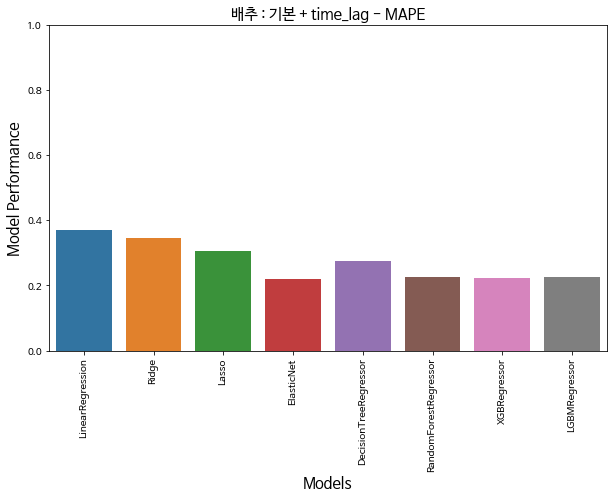

In [ ]:
# time_lag + 외부변수 사용 (기상 X)

modeling2(df, '배추', 7)

기상데이터 제외 -> linear model은 성능 안좋음, 트리기반 모델은 성능 향상

In [ ]:

# 2. 기본 + time_lag
def select_pum2(df, pum, time):
    df_apple = df[df['PUM_NM']==pum]
    df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday', 'domestic_mean', 'abroad_mean', 'output',
       'area', 'mean_price']]
    df_apple = mean_price(df_apple)
    df_apple = train_serise(df_apple, time) 
    df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple

In [ ]:
tips = pd.read_csv(base_path + 'DFII10.csv')
tips

,DATE,DFII10
0,2016-01-04,0.69
1,2016-01-05,0.69
2,2016-01-06,0.65
3,2016-01-07,0.66
4,2016-01-08,0.65
...,...,...
1233,2020-09-24,-0.91
1234,2020-09-25,-0.92
1235,2020-09-28,-0.94
1236,2020-09-29,-0.98


In [ ]:
tips['DATE'] = pd.to_datetime(tips['DATE'])
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1238 entries, 0 to 1237
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    1238 non-null   datetime64[ns]
 1   DFII10  1238 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 19.5+ KB


In [ ]:
tips = tips[tips['DATE'] < '2020-09-21']

In [ ]:
tips = tips.rename(columns = {'DATE' : 'SALEDATE'})
tips

,SALEDATE,DFII10
0,2016-01-04,0.69
1,2016-01-05,0.69
2,2016-01-06,0.65
3,2016-01-07,0.66
4,2016-01-08,0.65
...,...,...
1225,2020-09-14,-0.97
1226,2020-09-15,-0.99
1227,2020-09-16,-0.99
1228,2020-09-17,-0.97


In [ ]:
test = select_pum2(df, '배추', 7)
test

,SALEDATE,TOT_AMT,TOT_QTY,year,month,day,weekday,domestic_mean,abroad_mean,output,area,mean_price,p_lag_1,p_lag_2,p_lag_3,p_lag_4,p_lag_5,p_lag_6,p_lag_7,1week
0,2016-01-02,235334.00,719.00,2016.00,1.00,2.00,5.00,1189.00,323.00,1793392.00,24902.00,327.00,-1,-1,-1,-1,-1,-1,-1,398
1,2016-01-04,442059.00,926.00,2016.00,1.00,4.00,0.00,1187.00,323.00,1793392.00,24902.00,478.00,327,-1,-1,-1,-1,-1,-1,430
2,2016-01-05,386616.00,875.00,2016.00,1.00,5.00,1.00,1185.00,316.00,1793392.00,24902.00,442.00,478,327,-1,-1,-1,-1,-1,431
3,2016-01-06,359413.00,809.00,2016.00,1.00,6.00,2.00,1184.00,312.00,1793392.00,24902.00,444.00,442,478,327,-1,-1,-1,-1,437
4,2016-01-07,343541.00,771.00,2016.00,1.00,7.00,3.00,1182.00,291.00,1793392.00,24902.00,446.00,444,442,478,327,-1,-1,-1,452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,2020-09-17,2006305.00,1009.00,2020.00,9.00,17.00,3.00,1156.00,320.00,2242640.00,30950.00,1988.00,1962,2011,2045,1756,1582,1537,1576,1844
1469,2020-09-18,1822590.00,987.00,2020.00,9.00,18.00,4.00,1155.00,333.00,2242640.00,30950.00,1847.00,1988,1962,2011,2045,1756,1582,1537,1789
1470,2020-09-19,1536946.00,843.00,2020.00,9.00,19.00,5.00,1154.00,333.00,2242640.00,30950.00,1824.00,1847,1988,1962,2011,2045,1756,1582,1745
1471,2020-09-20,440815.00,151.00,2020.00,9.00,20.00,6.00,1154.00,333.00,2242640.00,30950.00,2925.00,1824,1847,1988,1962,2011,2045,1756,2896


In [ ]:
test2 = pd.merge(test, tips, how = 'left', on = 'SALEDATE')
test2

,SALEDATE,TOT_AMT,TOT_QTY,year,month,day,weekday,domestic_mean,abroad_mean,output,...,mean_price,p_lag_1,p_lag_2,p_lag_3,p_lag_4,p_lag_5,p_lag_6,p_lag_7,1week,DFII10
0,2016-01-02,235334.00,719.00,2016.00,1.00,2.00,5.00,1189.00,323.00,1793392.00,...,327.00,-1,-1,-1,-1,-1,-1,-1,398,NaN
1,2016-01-04,442059.00,926.00,2016.00,1.00,4.00,0.00,1187.00,323.00,1793392.00,...,478.00,327,-1,-1,-1,-1,-1,-1,430,0.69
2,2016-01-05,386616.00,875.00,2016.00,1.00,5.00,1.00,1185.00,316.00,1793392.00,...,442.00,478,327,-1,-1,-1,-1,-1,431,0.69
3,2016-01-06,359413.00,809.00,2016.00,1.00,6.00,2.00,1184.00,312.00,1793392.00,...,444.00,442,478,327,-1,-1,-1,-1,437,0.65
4,2016-01-07,343541.00,771.00,2016.00,1.00,7.00,3.00,1182.00,291.00,1793392.00,...,446.00,444,442,478,327,-1,-1,-1,452,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,2020-09-17,2006305.00,1009.00,2020.00,9.00,17.00,3.00,1156.00,320.00,2242640.00,...,1988.00,1962,2011,2045,1756,1582,1537,1576,1844,-0.97
1469,2020-09-18,1822590.00,987.00,2020.00,9.00,18.00,4.00,1155.00,333.00,2242640.00,...,1847.00,1988,1962,2011,2045,1756,1582,1537,1789,-0.97
1470,2020-09-19,1536946.00,843.00,2020.00,9.00,19.00,5.00,1154.00,333.00,2242640.00,...,1824.00,1847,1988,1962,2011,2045,1756,1582,1745,NaN
1471,2020-09-20,440815.00,151.00,2020.00,9.00,20.00,6.00,1154.00,333.00,2242640.00,...,2925.00,1824,1847,1988,1962,2011,2045,1756,2896,NaN


In [ ]:
test2[test2.DFII10.isna()]['SALEDATE']

0      2016-01-02
6      2016-01-09
12     2016-01-16
18     2016-01-23
24     2016-01-30
          ...    
1458   2020-09-05
1464   2020-09-12
1470   2020-09-19
1471   2020-09-20
1472   2020-09-21
Name: SALEDATE, Length: 262, dtype: datetime64[ns]

In [ ]:
test2 = test2.fillna(method='bfill')
test2[test2.DFII10.isna()]['SALEDATE']

1470   2020-09-19
1471   2020-09-20
1472   2020-09-21
Name: SALEDATE, dtype: datetime64[ns]

In [ ]:
test2.tail(10)

,SALEDATE,TOT_AMT,TOT_QTY,year,month,day,weekday,domestic_mean,abroad_mean,output,...,mean_price,p_lag_1,p_lag_2,p_lag_3,p_lag_4,p_lag_5,p_lag_6,p_lag_7,1week,DFII10
1463,2020-09-11,1279127.00,808.00,2020.00,9.00,11.00,4.00,1162.00,313.00,2242640.00,...,1582.00,1537,1576,1980,1629,1330,1355,1462,1824,-0.98
1464,2020-09-12,1390187.00,792.00,2020.00,9.00,12.00,5.00,1161.00,313.00,2242640.00,...,1756.00,1582,1537,1576,1980,1629,1330,1355,2925,-0.97
1465,2020-09-14,1716207.00,839.00,2020.00,9.00,14.00,0.00,1160.00,316.00,2242640.00,...,2045.00,1756,1582,1537,1576,1980,1629,1330,1809,-0.97
1466,2020-09-15,1846227.00,918.00,2020.00,9.00,15.00,1.00,1159.00,313.00,2242640.00,...,2011.00,2045,1756,1582,1537,1576,1980,1629,1835,-0.99
1467,2020-09-16,1826676.00,931.00,2020.00,9.00,16.00,2.00,1157.00,322.00,2242640.00,...,1962.00,2011,2045,1756,1582,1537,1576,1980,1821,-0.99
1468,2020-09-17,2006305.00,1009.00,2020.00,9.00,17.00,3.00,1156.00,320.00,2242640.00,...,1988.00,1962,2011,2045,1756,1582,1537,1576,1844,-0.97
1469,2020-09-18,1822590.00,987.00,2020.00,9.00,18.00,4.00,1155.00,333.00,2242640.00,...,1847.00,1988,1962,2011,2045,1756,1582,1537,1789,-0.97
1470,2020-09-19,1536946.00,843.00,2020.00,9.00,19.00,5.00,1154.00,333.00,2242640.00,...,1824.00,1847,1988,1962,2011,2045,1756,1582,1745,NaN
1471,2020-09-20,440815.00,151.00,2020.00,9.00,20.00,6.00,1154.00,333.00,2242640.00,...,2925.00,1824,1847,1988,1962,2011,2045,1756,2896,NaN
1472,2020-09-21,1727145.00,955.00,2020.00,9.00,21.00,0.00,1153.00,322.00,2242640.00,...,1809.00,2925,1824,1847,1988,1962,2011,2045,1865,NaN


In [ ]:
test2 = test2.fillna('-0.97')
test2[test2.DFII10.isna()]['SALEDATE']

Series([], Name: SALEDATE, dtype: datetime64[ns])

In [ ]:
test2 = test2.replace('.', np.NaN)
test2[test2.DFII10.isna()].shape

(78, 21)

In [ ]:
test2 = test2.fillna(method='bfill')
test2[test2.DFII10.isna()]['SALEDATE']

Series([], Name: SALEDATE, dtype: datetime64[ns])

In [ ]:
test2[test2.DFII10 == '.']['SALEDATE']

Series([], Name: SALEDATE, dtype: datetime64[ns])

In [ ]:
test2.info()

In [ ]:
test2['DFII10'] = test2['DFII10'].astype('float64')
test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1473 entries, 0 to 1472
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SALEDATE       1473 non-null   datetime64[ns]
 1   TOT_AMT        1473 non-null   float64       
 2   TOT_QTY        1473 non-null   float64       
 3   year           1473 non-null   float64       
 4   month          1473 non-null   float64       
 5   day            1473 non-null   float64       
 6   weekday        1473 non-null   float64       
 7   domestic_mean  1473 non-null   float64       
 8   abroad_mean    1473 non-null   float64       
 9   output         1473 non-null   float64       
 10  area           1473 non-null   float64       
 11  mean_price     1473 non-null   float64       
 12  p_lag_1        1473 non-null   int64         
 13  p_lag_2        1473 non-null   int64         
 14  p_lag_3        1473 non-null   int64         
 15  p_lag_4        1473 n

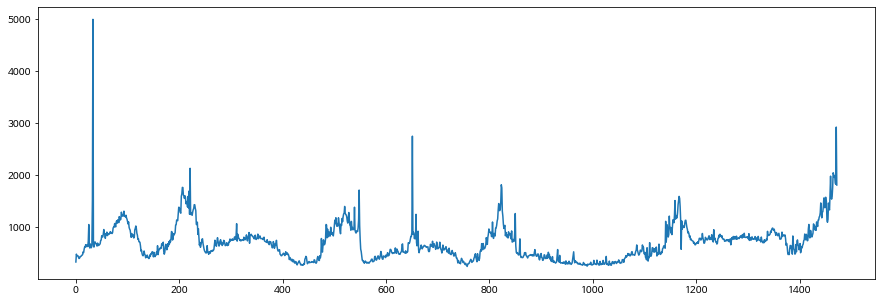

In [ ]:
test2.mean_price.plot(figsize = (15,5))

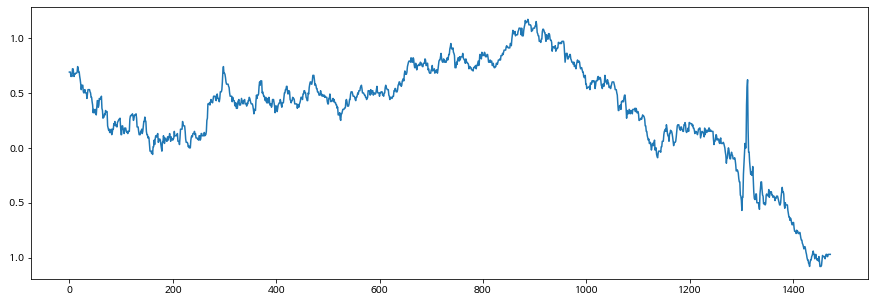

In [ ]:
test2.DFII10.plot(figsize = (15,5))

#### time_lag + 외부변수 (기상 X) + 금리정보

(1159, 19) (1159,) (314, 19) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 145.60it/s]


First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LinearRegression MAPE: 0.5304
2 FOLDS: LinearRegression MAPE: 0.4553
3 FOLDS: LinearRegression MAPE: 0.1979
4 FOLDS: LinearRegression MAPE: 0.3729
5 FOLDS: LinearRegression MAPE: 0.2480

LinearRegression mean MAPE: 0.3609
(1159, 19) (1159,) (314, 19) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 144.52it/s]


First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Ridge MAPE: 0.4724
2 FOLDS: Ridge MAPE: 0.4388
3 FOLDS: Ridge MAPE: 0.1948
4 FOLDS: Ridge MAPE: 0.3666
5 FOLDS: Ridge MAPE: 0.2220

Ridge mean MAPE: 0.3389
(1159, 19) (1159,) (314, 19) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 117.62it/s]


First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Lasso MAPE: 0.4608
2 FOLDS: Lasso MAPE: 0.3473
3 FOLDS: Lasso MAPE: 0.1811
4 FOLDS: Lasso MAPE: 0.3153
5 FOLDS: Lasso MAPE: 0.1650

Lasso mean MAPE: 0.2939
(1159, 19) (1159,) (314, 19) (314,)


ElasticNet Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579

ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 118.77it/s]



First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: ElasticNet MAPE: 0.1588
2 FOLDS: ElasticNet MAPE: 0.3404
3 FOLDS: ElasticNet MAPE: 0.1353
4 FOLDS: ElasticNet MAPE: 0.2378
5 FOLDS: ElasticNet MAPE: 0.2252

ElasticNet mean MAPE: 0.2195
(1159, 19) (1159,) (314, 19) (314,)


DecisionTreeRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 65.33it/s]


1 FOLDS: DecisionTreeRegressor MAPE: 0.5359
2 FOLDS: DecisionTreeRegressor MAPE: 0.4260
3 FOLDS: DecisionTreeRegressor MAPE: 0.3920
4 FOLDS: DecisionTreeRegressor MAPE: 0.2799
5 FOLDS: DecisionTreeRegressor MAPE: 0.2374

DecisionTreeRegressor mean MAPE: 0.3742
(1159, 19) (1159,) (314, 19) (314,)


RandomForestRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------


RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:01,  4.81it/s]

First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------


RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:02,  3.62it/s]

First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------


RandomForestRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:02,  2.79it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


RandomForestRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:02,  2.19it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.14it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2044
2 FOLDS: RandomForestRegressor MAPE: 0.3668
3 FOLDS: RandomForestRegressor MAPE: 0.2039
4 FOLDS: RandomForestRegressor MAPE: 0.2232
5 FOLDS: RandomForestRegressor MAPE: 0.1611

RandomForestRegressor mean MAPE: 0.2319
(1159, 19) (1159,) (314, 19) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 19.03it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
[02:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
[02:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
[02:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
[02:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 14.09it/s]


First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
[02:43:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.2831
2 FOLDS: XGBRegressor MAPE: 0.3065
3 FOLDS: XGBRegressor MAPE: 0.2112
4 FOLDS: XGBRegressor MAPE: 0.2421
5 FOLDS: XGBRegressor MAPE: 0.2763

XGBRegressor mean MAPE: 0.2638
(1159, 19) (1159,) (314, 19) (314,)


LGBMRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------


LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 15.81it/s]

First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.25it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LGBMRegressor MAPE: 0.2186
2 FOLDS: LGBMRegressor MAPE: 0.4017
3 FOLDS: LGBMRegressor MAPE: 0.1588
4 FOLDS: LGBMRegressor MAPE: 0.2174
5 FOLDS: LGBMRegressor MAPE: 0.1913

LGBMRegressor mean MAPE: 0.2376


,Model,Score
0,LinearRegression,0.36
1,Ridge,0.34
2,Lasso,0.29
3,ElasticNet,0.22
4,DecisionTreeRegressor,0.37
5,RandomForestRegressor,0.23
6,XGBRegressor,0.26
7,LGBMRegressor,0.24


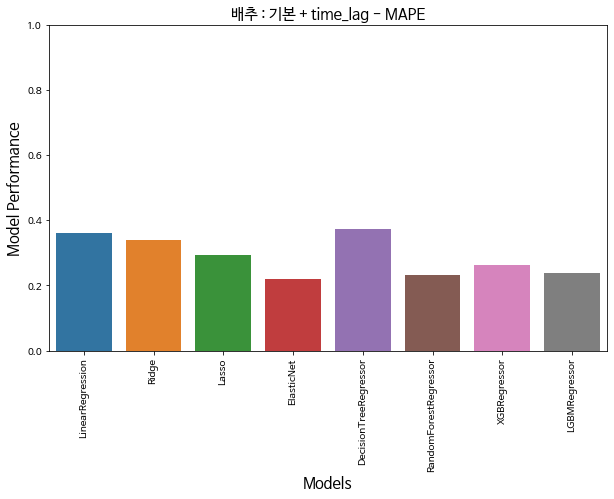

In [ ]:
modeling2(test2)

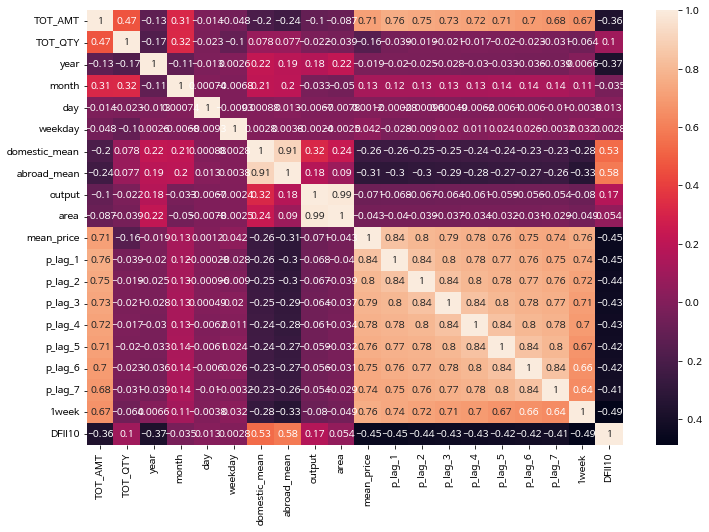

In [ ]:
plt.figure(figsize= (12,8))
sns.heatmap(test2.corr(), annot = True)
plt.show()

#### time_lag, ...etc



(1159, 12) (1159,) (314, 12) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 95.12it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LinearRegression MAPE: 0.1136
2 FOLDS: LinearRegression MAPE: 0.1443
3 FOLDS: LinearRegression MAPE: 0.1180
4 FOLDS: LinearRegression MAPE: 0.1285
5 FOLDS: LinearRegression MAPE: 0.0965

LinearRegression mean MAPE: 0.1202


(1159, 12) (1159,) (314, 12) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 153.93it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Ridge MAPE: 0.1154
2 FOLDS: Ridge MAPE: 0.1520
3 FOLDS: Ridge MAPE: 0.1164
4 FOLDS: Ridge MAPE: 0.1313
5 FOLDS: Ridge MAPE: 0.0980

Ridge mean MAPE: 0.1226


(1159, 12) (1159,) (314, 12) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 117.21it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Lasso MAPE: 0.1154
2 FOLDS: Lasso MAPE: 0.1517
3 FOLDS: Lasso MAPE: 0.1149
4 FOLDS: Lasso MAPE: 0.1332
5 FOLDS: Lasso MAPE: 0.1000

Lasso mean MAPE: 0.1230


(1159, 12) (1159,) (314, 12) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 142.49it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: ElasticNet MAPE: 0.1410
2 FOLDS: ElasticNet MAPE: 0.3351
3 FOLDS: ElasticNet MAPE: 0.1827
4 FOLDS: ElasticNet MAPE: 0.2330
5 FOLDS: ElasticNet MAPE: 0.2089

ElasticNet mean MAPE: 0.2201


(1159, 12) (1159,) (314, 12) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 109.69it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: DecisionTreeRegressor MAPE: 0.2631
2 FOLDS: DecisionTreeRegressor MAPE: 0.3508
3 FOLDS: DecisionTreeRegressor MAPE: 0.1906
4 FOLDS: DecisionTreeRegressor MAPE: 0.1877
5 FOLDS: DecisionTreeRegressor MAPE: 0.1676

DecisionTreeRegressor mean MAPE: 0.2320


(1159, 12) (1159,) (314, 12) (314,)


RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:01,  5.68it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------


RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:01,  4.20it/s]

First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------


RandomForestRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:02,  3.30it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


RandomForestRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:02,  2.66it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  2.60it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1641
2 FOLDS: RandomForestRegressor MAPE: 0.3138
3 FOLDS: RandomForestRegressor MAPE: 0.1443
4 FOLDS: RandomForestRegressor MAPE: 0.1550
5 FOLDS: RandomForestRegressor MAPE: 0.1316

RandomForestRegressor mean MAPE: 0.1817
(1159, 12) (1159,) (314, 12) (314,)


XGBRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
[03:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:01,  5.48it/s]

First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
[03:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
[03:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
[03:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
[03:02:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  6.11it/s]


1 FOLDS: XGBRegressor MAPE: 0.2149
2 FOLDS: XGBRegressor MAPE: 0.3244
3 FOLDS: XGBRegressor MAPE: 0.1578
4 FOLDS: XGBRegressor MAPE: 0.1865
5 FOLDS: XGBRegressor MAPE: 0.1444

XGBRegressor mean MAPE: 0.2056
(1159, 12) (1159,) (314, 12) (314,)


LGBMRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------


LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 15.37it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.23it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1505
2 FOLDS: LGBMRegressor MAPE: 0.3350
3 FOLDS: LGBMRegressor MAPE: 0.1488
4 FOLDS: LGBMRegressor MAPE: 0.1676
5 FOLDS: LGBMRegressor MAPE: 0.1219

LGBMRegressor mean MAPE: 0.1847


,Model,Score
0,LinearRegression,0.12
1,Ridge,0.12
2,Lasso,0.12
3,ElasticNet,0.22
4,DecisionTreeRegressor,0.23
5,RandomForestRegressor,0.18
6,XGBRegressor,0.21
7,LGBMRegressor,0.18


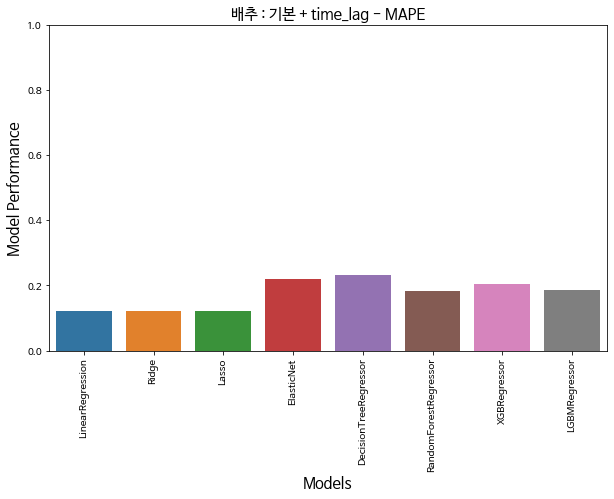

In [ ]:
modeling2(df, '배추', 7)

(1159, 12) (1159,) (314, 12) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 168.24it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LinearRegression MAPE: 0.1352
2 FOLDS: LinearRegression MAPE: 0.0583
3 FOLDS: LinearRegression MAPE: 0.0458
4 FOLDS: LinearRegression MAPE: 0.0731
5 FOLDS: LinearRegression MAPE: 0.0670

LinearRegression mean MAPE: 0.0759


(1159, 12) (1159,) (314, 12) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 171.94it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Ridge MAPE: 0.1305
2 FOLDS: Ridge MAPE: 0.0592
3 FOLDS: Ridge MAPE: 0.0461
4 FOLDS: Ridge MAPE: 0.0738
5 FOLDS: Ridge MAPE: 0.0675

Ridge mean MAPE: 0.0754


(1159, 12) (1159,) (314, 12) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 130.35it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: Lasso MAPE: 0.1273
2 FOLDS: Lasso MAPE: 0.0592
3 FOLDS: Lasso MAPE: 0.0463
4 FOLDS: Lasso MAPE: 0.0745
5 FOLDS: Lasso MAPE: 0.0680

Lasso mean MAPE: 0.0750


(1159, 12) (1159,) (314, 12) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 151.57it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: ElasticNet MAPE: 0.1337
2 FOLDS: ElasticNet MAPE: 0.0905
3 FOLDS: ElasticNet MAPE: 0.0689
4 FOLDS: ElasticNet MAPE: 0.1218
5 FOLDS: ElasticNet MAPE: 0.1091

ElasticNet mean MAPE: 0.1048


(1159, 12) (1159,) (314, 12) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 114.01it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: DecisionTreeRegressor MAPE: 0.1727
2 FOLDS: DecisionTreeRegressor MAPE: 0.1922
3 FOLDS: DecisionTreeRegressor MAPE: 0.0769
4 FOLDS: DecisionTreeRegressor MAPE: 0.1648
5 FOLDS: DecisionTreeRegressor MAPE: 0.1527

DecisionTreeRegressor mean MAPE: 0.1518


(1159, 12) (1159,) (314, 12) (314,)


RandomForestRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------


RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:01,  4.60it/s]

First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------


RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:02,  3.75it/s]

First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------


RandomForestRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:02,  3.14it/s]

First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


RandomForestRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:02,  2.60it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  2.53it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1394
2 FOLDS: RandomForestRegressor MAPE: 0.1068
3 FOLDS: RandomForestRegressor MAPE: 0.0532
4 FOLDS: RandomForestRegressor MAPE: 0.1018
5 FOLDS: RandomForestRegressor MAPE: 0.1071

RandomForestRegressor mean MAPE: 0.1017
(1159, 12) (1159,) (314, 12) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 23.30it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
[03:04:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
[03:04:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
[03:04:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------
[03:04:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 16.99it/s]


First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
[03:04:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1238
2 FOLDS: XGBRegressor MAPE: 0.1071
3 FOLDS: XGBRegressor MAPE: 0.0593
4 FOLDS: XGBRegressor MAPE: 0.1049
5 FOLDS: XGBRegressor MAPE: 0.1000

XGBRegressor mean MAPE: 0.0990
(1159, 12) (1159,) (314, 12) (314,)


LGBMRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 16.60it/s]

First train_day: 0	 Last train_day: 193
First val_day: 194	 Last val_day: 386
----------------------------------------
First train_day: 0	 Last train_day: 386
First val_day: 387	 Last val_day: 579
----------------------------------------
First train_day: 0	 Last train_day: 579
First val_day: 580	 Last val_day: 772
----------------------------------------
First train_day: 0	 Last train_day: 772
First val_day: 773	 Last val_day: 965
----------------------------------------


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.40it/s]

First train_day: 0	 Last train_day: 965
First val_day: 966	 Last val_day: 1158
----------------------------------------
1 FOLDS: LGBMRegressor MAPE: 0.1222
2 FOLDS: LGBMRegressor MAPE: 0.1032
3 FOLDS: LGBMRegressor MAPE: 0.0564
4 FOLDS: LGBMRegressor MAPE: 0.0968
5 FOLDS: LGBMRegressor MAPE: 0.1000

LGBMRegressor mean MAPE: 0.0957


,Model,Score
0,LinearRegression,0.08
1,Ridge,0.08
2,Lasso,0.08
3,ElasticNet,0.10
4,DecisionTreeRegressor,0.15
5,RandomForestRegressor,0.10
6,XGBRegressor,0.10
7,LGBMRegressor,0.10


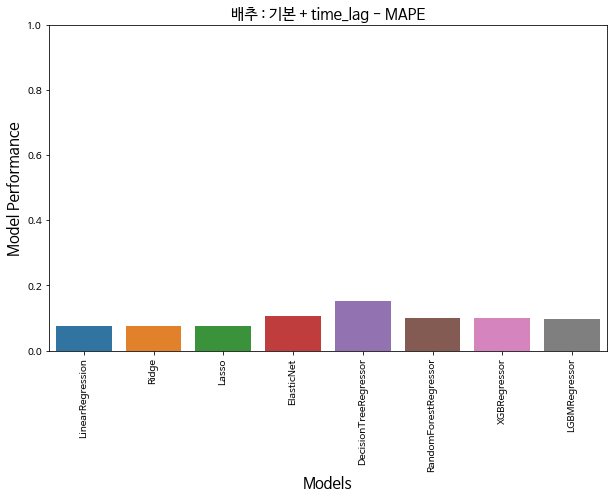

In [ ]:
modeling2(df, '사과', 7)

#### 환율

In [ ]:
my = pd.read_csv(base_path + '주요국 통화의 대원화환율_17121850.csv')
my

,변환,원자료
0,2015/01/02,"1,099.20"
1,2015/01/05,"1,102.60"
2,2015/01/06,"1,108.70"
3,2015/01/07,"1,103.90"
4,2015/01/08,"1,099.70"
...,...,...
1476,2020/12/24,"1,108.90"
1477,2020/12/28,"1,103.70"
1478,2020/12/29,"1,098.20"
1479,2020/12/30,"1,093.20"


In [ ]:
my.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481 entries, 0 to 1480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   변환      1481 non-null   object
 1   원자료     1481 non-null   object
dtypes: object(2)
memory usage: 23.3+ KB


In [ ]:
tips['DATE'] = pd.to_datetime(tips['DATE'])
tips.info()

# 정리

1. 7일 예측 기준

- time_lag : 7일
- 시계열 특징 : 요일 X, 잔차, 트렌드, 시즌 O
- 이동평균선 : 가격, 표준편차 O / 거래량 X
- 기상데이터 X / 다른 외부변수 X
- 경제 지표 X (ex. 환율, 금리)
- 각 품종별 이상치 제거<br><br>

2. 1년 예측<br>
외부변수의 영향이 커질것으로 예상

- time_lag : 7일
- 시계열 특징 : 요일 X, 잔차, 트렌드, 시즌 O
- 이동평균선 : 가격, 표준편차 O / 거래량 X
- 기상데이터 X / 다른 외부변수 O
- 경제 지표 O (ex. 환율, 금리)
- 각 품종별 이상치 제거



In [ ]:
df1= df.copy()

In [ ]:
df1.columns

Index(['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday', 'domestic_mean', 'abroad_mean', 'output',
       'area', '소비자물가지수', '지점명', '온도(최저)', '온도(평균)', '온도(최고)', '지면온도(최저)',
       '지면온도(평균)', '지면온도(최고)', '풍속(m/s)(평균)', '습도(%)(평균)', '강수량(mm)(합계)',
       '적설량(cm)(합계)', '일조량(합계)', '일조량(평균)', 'mean_price'],
      dtype='object')

## 코드

- 아래 코드 복붙해서 사용하면 됩니다
    - ex) modeling2(df, '배추', 7) 
    - time_lag 7일
    - df는 modeling_data1(완).parquet 파일 사용

In [ ]:
# 함수화

def split_train_and_test(df, date, week):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train = df[df['SALEDATE'] < date]
    test = df[df['SALEDATE'] >= date]
    del train['SALEDATE']
    del test['SALEDATE']
    y_train = train.pop(f'{week}week')
    x_train=train.copy()
    y_test = test.pop(f'{week}week')
    x_test=test.copy()
    return x_train,y_train,x_test,y_test

def eval_model(y_test,pred):
    y_true, y_pred = np.array(y_test), np.array(pred)
    mae = mean_absolute_error(y_true, pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print('mae:',mae,'mape:',mape, 'mse:',mse)
    return mae, mape, mse

#시각화 그래프 
def eval_visul(y_test,pred,title,week):
    y_test=y_test.reset_index()[f'{week}week']
    plt.figure(figsize=(20,5))
    plt.title(title, fontsize = 25)
    plt.plot(y_test, label='true')
    plt.plot(pred, label='pred')
    plt.legend()
    plt.show()
    eval_model(y_test,pred)

def mean_price(df_apple):
    df_apple=df_apple.groupby(['SALEDATE']).mean()
    df_apple['mean_price']=df_apple['TOT_AMT']/df_apple['TOT_QTY']
    #사용된 총금액과 총거래량은 제거
    # df_apple=df_apple.drop(columns=['TOT_AMT','TOT_QTY'])
    df_apple=df_apple.reset_index()
    df_apple = df_apple.round()
    #날짜 컬럼 추가
    # df_apple['year'] = df_apple['SALEDATE'].dt.year
    # df_apple['month'] = df_apple['SALEDATE'].dt.month
    # df_apple['day'] = df_apple['SALEDATE'].dt.day
    # df_apple['weekday'] = df_apple['SALEDATE'].dt.weekday
    return df_apple


#n주일 후 가격을 예측하는 컬럼을 추가 
#df-> 예측기간 가격이 0으로 나오는 값 제외, 따로 변수로 지정
def forcast_week(df,week):
    df[f'{week}week']=0
    
    for index in range(len(df)):
        try:df[f'{week}week'][index] = df['mean_price'][index+7*week]
        except:continue
    df_week=df.iloc[-7*week:]
    df = df.drop(df.iloc[-7*week:].index)
    return df, df_week

def forcast_1week(df_1):
    df_1['1week']=0
    for index in range(len(df_1)):
        try:df_1['1week'][index] = df_1['mean_price'][index+7]
        except:continue
    #df_1_week=df_1.iloc[-7*week:]
    df_1 = df_1.drop(df_1.iloc[-7:].index)
    return df_1

# time_lag
def train_serise(df_apple, time):
    for lag in range(1,time + 1):
        df_apple[f'p_lag_{lag}'] = -1
        #df_apple[f'q_lag_{lag}'] = -1
        for index in range(lag, len(df_apple)):
            df_apple.loc[index, f'p_lag_{lag}'] = df_apple['mean_price'][index-lag] #1일전, 2일전, ... 가격을 feature로 추가
            #df_apple.loc[index, f'q_lag_{lag}'] = df_apple['TOT_QTY'][index-lag] #1일전, 2일전, ... 거래량을 feature로 추가
    return df_apple


#요일컬럼 추가 -> 원 핫 인코딩
def weekday(df_test):
    weekday=['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    df_test['요일']=0
    for i in range(len(df_test)):
        df_test['요일'][i]=weekday[df_test['SALEDATE'][i].weekday()]
    df_test = pd.concat([df_test, pd.get_dummies(df_test['요일'])], axis=1)
    df_test =df_test.drop(columns='요일')
    return df_test

#시계열 분해 잔차활용
def resid(df):
    date_resid=STL(df[['SALEDATE','mean_price']].set_index('SALEDATE'), period=12)
    df['resid']=date_resid.fit().resid.values
    return df

#시계열 분해 트렌드활용
def trend(df):
    date_resid=STL(df[['SALEDATE','mean_price']].set_index('SALEDATE'), period=12)
    df['trend']=date_resid.fit().trend.values
    return df

#시계열 분해 시즌활용
def season(df):
    date_resid=STL(df[['SALEDATE','mean_price']].set_index('SALEDATE'), period=12)
    df['season']=date_resid.fit().seasonal.values
    return df

In [ ]:
# 7일 예측 기준
def select_pum2(df, pum, time):
    df_apple = df[df['PUM_NM']==pum]
    df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY']]
    df_apple = mean_price(df_apple)
    # time_lag
    df_apple = train_serise(df_apple, time)
    # 시계열 관련 feature
    df_apple = resid(df_apple)
    df_apple = trend(df_apple)
    df_apple = season(df_apple)
    # 가격 관련 이동평균선
    df_apple = add_price(df_apple)
    df_apple = add_std_price(df_apple)
    df_apple = df_apple.dropna(axis=0)
    df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    df_apple = df_apple.reset_index(drop = True)
    return df_apple


def pre_2(df, pum, time) : 
    df_pum=select_pum2(df, pum, time)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = StandardScaler()
    # scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test

def mape_cv2(model, df, pum, time):
    train_X, test_X, train_y, test_y = pre_2(df, pum, time)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X)), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        print("First train_day: {}\t Last train_day: {}".format(X_train[:1].index[0], X_train[-1:].index[0]))
        print("First val_day: {}\t Last val_day: {}".format(X_test[:1].index[0], X_test[-1:].index[0]))
        print('-' * 40)
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list


def print_mape_score2(model, df, pum, time):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv2(model, df, pum, time)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def modeling2(df, pum, time) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score2(model, df, pum, time)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'배추 7일 예측 MAPE', fontsize=15)
    plt.show()

In [ ]:
reg2 = LinearRegression()
ridge2 = Ridge()
lasso2 = Lasso()
Enet2 = ElasticNet()
DTree2 = DecisionTreeRegressor()
rf2 = RandomForestRegressor()
model_xgb2 = XGBRegressor()
model_lgb2 = LGBMRegressor()

In [ ]:
# test

select_pum2(df, '배추', 7)

,SALEDATE,TOT_AMT,TOT_QTY,mean_price,p_lag_1,p_lag_2,p_lag_3,p_lag_4,p_lag_5,p_lag_6,...,resid,trend,season,mean_price_5,mean_price_30,ratio_mean_price_5_30,std_price_5,std_price_30,ratio_std_price_5_30,1week
0,2016-01-27,576263.00,891.00,647.00,621,660,614,616,573,509,...,-794.27,655.19,786.08,616.80,482.81,1.28,30.87,87.47,0.35,674
1,2016-01-28,597760.00,909.00,658.00,647,621,660,614,616,573,...,104.44,668.43,-114.88,631.60,498.05,1.27,20.67,86.84,0.24,608
2,2016-01-29,597151.00,956.00,624.00,658,647,621,660,614,616,...,66.01,686.49,-128.50,640.00,506.62,1.26,21.27,93.40,0.23,601
3,2016-01-30,628222.00,860.00,730.00,624,658,647,621,660,614,...,97.77,723.25,-91.02,642.00,515.29,1.25,18.51,95.52,0.19,663
4,2016-01-31,184400.00,176.00,1048.00,730,624,658,647,621,660,...,261.72,779.52,6.76,656.00,528.90,1.24,44.19,104.79,0.42,1517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,2020-09-17,2006305.00,1009.00,1988.00,1962,2011,2045,1756,1582,1537,...,17.66,1924.99,45.35,1871.20,1550.62,1.21,196.79,279.38,0.70,0
1448,2020-09-18,1822590.00,987.00,1847.00,1988,1962,2011,2045,1756,1582,...,32.73,1940.71,-126.45,1952.40,1571.00,1.24,113.95,295.26,0.39,0
1449,2020-09-19,1536946.00,843.00,1824.00,1847,1988,1962,2011,2045,1756,...,25.12,1958.16,-159.29,1970.60,1591.43,1.24,75.53,298.96,0.25,0
1450,2020-09-20,440815.00,151.00,2925.00,1824,1847,1988,1962,2011,2045,...,285.96,1975.92,663.13,1926.40,1613.00,1.19,85.16,298.61,0.29,0


(1138, 19) (1138,) (314, 19) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 151.28it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: LinearRegression MAPE: 0.1301
2 FOLDS: LinearRegression MAPE: 0.1931
3 FOLDS: LinearRegression MAPE: 0.1222
4 FOLDS: LinearRegression MAPE: 0.1443
5 FOLDS: LinearRegression MAPE: 0.1124

LinearRegression mean MAPE: 0.1404


(1138, 19) (1138,) (314, 19) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 125.79it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: Ridge MAPE: 0.1116
2 FOLDS: Ridge MAPE: 0.1958
3 FOLDS: Ridge MAPE: 0.1229
4 FOLDS: Ridge MAPE: 0.1464
5 FOLDS: Ridge MAPE: 0.1141

Ridge mean MAPE: 0.1382


(1138, 19) (1138,) (314, 19) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 83.96it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: Lasso MAPE: 0.1044
2 FOLDS: Lasso MAPE: 0.1970
3 FOLDS: Lasso MAPE: 0.1240
4 FOLDS: Lasso MAPE: 0.1494
5 FOLDS: Lasso MAPE: 0.1158

Lasso mean MAPE: 0.1381


(1138, 19) (1138,) (314, 19) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 145.10it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: ElasticNet MAPE: 0.1363
2 FOLDS: ElasticNet MAPE: 0.2890
3 FOLDS: ElasticNet MAPE: 0.1764
4 FOLDS: ElasticNet MAPE: 0.2266
5 FOLDS: ElasticNet MAPE: 0.2208

ElasticNet mean MAPE: 0.2098


(1138, 19) (1138,) (314, 19) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 88.04it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
1 FOLDS: DecisionTreeRegressor MAPE: 0.2920
2 FOLDS: DecisionTreeRegressor MAPE: 0.4455
3 FOLDS: DecisionTreeRegressor MAPE: 0.2463
4 FOLDS: DecisionTreeRegressor MAPE: 0.2316
5 FOLDS: DecisionTreeRegressor MAPE: 0.1857

DecisionTreeRegressor mean MAPE: 0.2802


(1138, 19) (1138,) (314, 19) (314,)


RandomForestRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------


RandomForestRegressor Cross Validations...:  10%|█         | 1/10 [00:00<00:01,  4.78it/s]

First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------


RandomForestRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:02,  3.33it/s]

First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------


RandomForestRegressor Cross Validations...:  30%|███       | 3/10 [00:01<00:02,  2.52it/s]

First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------


RandomForestRegressor Cross Validations...:  40%|████      | 4/10 [00:01<00:03,  1.99it/s]

First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.95it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1463
2 FOLDS: RandomForestRegressor MAPE: 0.3944
3 FOLDS: RandomForestRegressor MAPE: 0.1497
4 FOLDS: RandomForestRegressor MAPE: 0.1616
5 FOLDS: RandomForestRegressor MAPE: 0.1344

RandomForestRegressor mean MAPE: 0.1973
(1138, 19) (1138,) (314, 19) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 19.27it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
[03:45:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
[03:45:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
[03:45:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------
[03:45:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 13.40it/s]

First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------
[03:45:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 12.27it/s]


1 FOLDS: XGBRegressor MAPE: 0.1593
2 FOLDS: XGBRegressor MAPE: 0.4546
3 FOLDS: XGBRegressor MAPE: 0.1479
4 FOLDS: XGBRegressor MAPE: 0.1768
5 FOLDS: XGBRegressor MAPE: 0.1774

XGBRegressor mean MAPE: 0.2232
(1138, 19) (1138,) (314, 19) (314,)


LGBMRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 17.58it/s]

First train_day: 0	 Last train_day: 192
First val_day: 193	 Last val_day: 381
----------------------------------------
First train_day: 0	 Last train_day: 381
First val_day: 382	 Last val_day: 570
----------------------------------------
First train_day: 0	 Last train_day: 570
First val_day: 571	 Last val_day: 759
----------------------------------------
First train_day: 0	 Last train_day: 759
First val_day: 760	 Last val_day: 948
----------------------------------------


LGBMRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00,  7.46it/s]

First train_day: 0	 Last train_day: 948
First val_day: 949	 Last val_day: 1137
----------------------------------------


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  6.59it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1551
2 FOLDS: LGBMRegressor MAPE: 0.3336
3 FOLDS: LGBMRegressor MAPE: 0.1464
4 FOLDS: LGBMRegressor MAPE: 0.1760
5 FOLDS: LGBMRegressor MAPE: 0.1494

LGBMRegressor mean MAPE: 0.1921


,Model,Score
0,LinearRegression,0.14
1,Ridge,0.14
2,Lasso,0.14
3,ElasticNet,0.21
4,DecisionTreeRegressor,0.28
5,RandomForestRegressor,0.20
6,XGBRegressor,0.22
7,LGBMRegressor,0.19


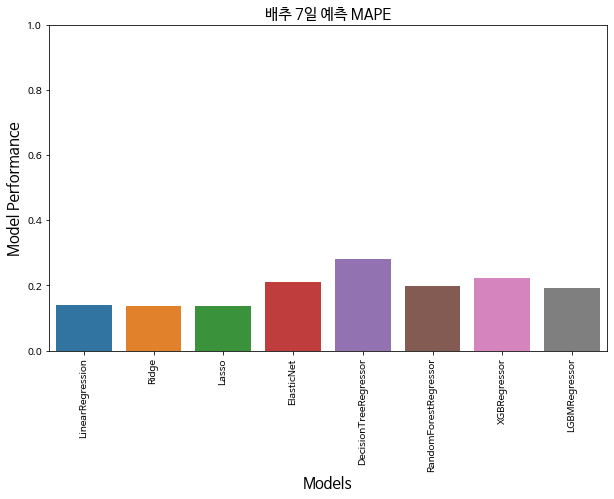

In [ ]:
# test

modeling2(df, '배추', 7)